In [1]:
# imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats import multitest
from scipy import stats
from scipy.stats import levene, norm
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib
import seaborn as sns
from matplotlib.colors import to_rgb
import colorsys
import itertools

plt.rcParams['figure.dpi'] = 600
colors = plt.colormaps["Dark2"].colors
from tqdm import tqdm

# silence warnings because the NN has a lot of them
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from optuna import create_study
from optuna.trial import Trial
from tensorflow.keras import backend as K
import random

# for saving model params
import pickle

# for feature importance
import shap
from sklearn.metrics import mean_squared_error
import copy
import ast

# Read Model Outputs

All of these .pkl files are generated by `models.ipynb`.

In [2]:
try:
    df_condition_level_data = pd.read_csv('../outputs/condition_level_group_advantage_with_ivs.csv') # mark's version of the cleaning

    # read the models and results from the previous save

    # main models
    with open('../outputs/models.pkl', 'rb') as f:
        MODELS = pickle.load(f)
    with open('../outputs/model_r2_results.pkl', 'rb') as f:
        MODEL_R2_RESULTS = pickle.load(f)
    with open('../outputs/model_rmse_results.pkl', 'rb') as f:
        MODEL_RMSE_RESULTS = pickle.load(f)
    
    # train/test data
    with open('../outputs/train_test_data.pkl', 'rb') as f:
        TRAIN_TEST_DATA = pickle.load(f)

    # bootstrap models and results
    with open('../outputs/bootstrap_r2_results.pkl', 'rb') as f:
        BOOTSTRAP_R2_RESULTS = pickle.load(f)
    with open('../outputs/bootstrap_models.pkl', 'rb') as f:
        BOOTSTRAP_MODELS = pickle.load(f)
    with open('../outputs/bootstrap_rmse_results.pkl', 'rb') as f:
        BOOTSTRAP_RMSE_RESULTS = pickle.load(f)

    # IV lists
    with open('../outputs/iv_lists.pkl', 'rb') as f:
        IV_LISTS = pickle.load(f)
    
    basic_IVs = IV_LISTS['basic_IVs']
    mcgrath_continuous = IV_LISTS['mcgrath_continuous']
    steiner_continuous = IV_LISTS['steiner_continuous']
    laughlin_continuous = IV_LISTS['laughlin_continuous']
    categorical_IVs = IV_LISTS['categorical_IVs']

except FileNotFoundError:
    print("Model files not found. Please run models.ipynb first to generate the outputs.")

# Model-Related Helper Functions

Duplicated from models.ipynb, these helper functions help us run and evaluate the models live as we plot them.

In [3]:
def custom_r2(y_pred, y_actual, wave_a_data, wave_b_data, dv_type):
    # Compute R^2 on the test set, using the training set as a baseline
    naive_prediction_errs = []
    for i, row in wave_b_data.iterrows():
        
        # get all instances of groups of the same size performing 
        # all the tasks in the training set at the same complexity level.
        playerCount = row["playerCount"]
        wave_a_subset = wave_a_data[(wave_a_data["playerCount"] == playerCount) & 
                                    (wave_a_data["Low"] == row["Low"]) & 
                                    (wave_a_data["Medium"] == row["Medium"]) &
                                    (wave_a_data["High"] == row["High"])]
        y_training = np.mean(wave_a_subset[dv_type])
        # predict the value of the DV (in wave_b) using the mean of the training data (from wave_a)
        y_actual_i = row[dv_type]
        fold_err = (y_actual_i - y_training)**2
        naive_prediction_errs.append(fold_err)

    r2 = 1 - np.sum((y_pred - y_actual)**2) / np.sum(naive_prediction_errs)
    
    return r2

In [4]:
def add_interactions(X):
    poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    return poly.fit_transform(X)

def get_rmse(y_true, y_pred):
    """
    Calculate RMSE between true and predicted values.
    """
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# function for getting RMSE from a trained model (OLS)
def get_rmse_ols(model_ols, X_test, y_true, ivs):
    X_test_ols = sm.add_constant(X_test[ivs].copy(), has_constant='add')
    y_pred_ols = model_ols.predict(X_test_ols)
    rmse_ols = get_rmse(y_true, y_pred_ols)

    return rmse_ols

def get_rmse_for_enet(model_enet, X_test, y_true, ivs):
    X_test_enet = add_interactions(X_test[ivs].copy())
    y_pred_enet = model_enet.predict(X_test_enet)
    rmse_enet = get_rmse(y_true, y_pred_enet)

    return rmse_enet

In [5]:
def set_random_seeds(seed_value=19104):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

# Task Space / Group Advantage Figures

### Plotting Preprocessing

First, we need to take the results dictionaries and wrangle them so that we can plot them better.

In [6]:
def create_plotting_dataframe(results_dict, train_test_data, metric_type):

    # metric types
    assert metric_type in ["R^2", "RMSE"], "metric_type must be either 'R^2' or 'RMSE'"

    plot_rows = []
    for iv, model_dict in results_dict.items():
        for model, wave_dict in model_dict.items():
            for wave, dv_dict in wave_dict.items():
                n_train = train_test_data[wave]["train"].shape[0]
                for dv_type, r2_val in dv_dict.items():
                    plot_rows.append({
                        "IV": iv,
                        "Model": model,
                        "Wave": wave,
                        "n_train": n_train,
                        "DV_Type": dv_type,
                        metric_type: r2_val,
                        "IV-Model": f"{iv}-{model}"
                    })
    return pd.DataFrame(plot_rows)


df_plot_r2 = create_plotting_dataframe(MODEL_R2_RESULTS, TRAIN_TEST_DATA, "R^2")
df_plot_rmse = create_plotting_dataframe(MODEL_RMSE_RESULTS, TRAIN_TEST_DATA, "RMSE")

### Plotting Globals

Some general settings for colors to match the different models/types.

In [7]:
# Map wave names to pretty x-axis labels
wave_pretty = {
    "Wave 1a": "5",
    "Wave 1": "10",
    "Wave 2": "15"
}

# set up df_plot versions
df_plot_r2["Wave_Label"] = df_plot_r2["Wave"].map(wave_pretty)
df_plot_rmse["Wave_Label"] = df_plot_rmse["Wave"].map(wave_pretty)

# remove NN for now
if "NN" in df_plot_r2["Model"].unique() or "NN" in df_plot_rmse["Model"].unique():
    df_plot_r2 = df_plot_r2[df_plot_r2["Model"] != "NN"]
    df_plot_rmse = df_plot_rmse[df_plot_rmse["Model"] != "NN"]

# For ordering on x-axis
cat_order = [
    "5",
    "10",
    "15"
]

# Hue color logic
base_palette = {
    "Task Space": "#1f77b4",   # blue family
    "McGrath Categorical": "#ff7f0e",  # orange family
    "McGrath Subspace": "#2ca02c",  # green family
    "Steiner Subspace": "#d62728",  # red family
    "Laughlin Subspace": "#9467bd"  # purple family
}

marker_dict = {
    "Task Space-OLS":"o","Task Space-E-Net":"s",
    "McGrath Categorical-OLS":"^","McGrath Categorical-E-Net":"v",
    "McGrath Subspace-OLS":"P","McGrath Subspace-E-Net":"X",
    "Steiner Subspace-OLS":"D", "Steiner Subspace-E-Net":"*",
    "Laughlin Subspace-OLS":"h", "Laughlin Subspace-E-Net":">"
}

shade_dict = {
    "OLS": 1.55,
    "E-Net": 1.00,
}

def get_color(iv, model):
    base = base_palette[iv]
    r, g, b = to_rgb(base)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    l_new = min(1.0, max(0, l * shade_dict[model]))
    r2, g2, b2 = colorsys.hls_to_rgb(h, l_new, s)
    return (r2, g2, b2)

For SHAP/Permutation analysis, we need to group strongly correlated columns together because this prevents another "copy" of the same dimension from existing in the model, unpermuted.

In [8]:
# Define Task Space Groups
pretty_feature_cluster_names = {
    "['Type 2 (Generate)', 'Creativity Input']": "Creative",
    "['Type 3 and Type 4 (Objective Correctness)', 'Decision Verifiability', 'Shared Knowledge', 'Within-System Solution', 'Answer Recognizability', 'Time Solvability', 'Intellective-Judgmental']": "Demonstrably Correct Answer",
    "['Conceptual-Behavioral', 'Intellectual-Manipulative']": "Physical",
    "Type 1 (Planning)": "Type 1 (Planning)",
    "Type 5 (Cognitive Conflict)": "Type 5 (Cognitive Conflict)",
    "Type 6 (Mixed-Motive)": "Type 6 (Mixed-Motive)",
    "Type 7 (Battle)": "Type 7 (Battle)",
    "Type 8 (Performance)": "Type 8 (Performance)",
    "Divisible-Unitary": "Divisible-Unitary",
    "Maximizing": "Maximizing",
    "Optimizing": "Optimizing",
    "Outcome Multiplicity": "Outcome Multiplicity",
    "Solution Scheme Multiplicity": "Solution Scheme Multiplicity",
    "Conflicting Tradeoffs": "Conflicting Tradeoffs",
    "Solution Scheme Outcome Uncertainty": "Solution Scheme Outcome Uncertainty",
    "Eureka Question": "Eureka Question"
}

Show that the clusters are correlated:

In [9]:
df_condition_level_data[['Type 2 (Generate)', 'Creativity Input']].corr()

Type 2 (Generate)  Creativity Input
Type 2 (Generate)           1.000000          0.829328
Creativity Input            0.829328          1.000000

In [10]:
df_condition_level_data[['Type 3 and Type 4 (Objective Correctness)', 'Decision Verifiability', 'Shared Knowledge', 'Within-System Solution', 'Answer Recognizability', 'Time Solvability', 'Intellective-Judgmental']].corr()

Type 3 and Type 4 (Objective Correctness)  \
Type 3 and Type 4 (Objective Correctness)                                   1.000000   
Decision Verifiability                                                      0.967066   
Shared Knowledge                                                            0.928585   
Within-System Solution                                                      0.654567   
Answer Recognizability                                                      0.959369   
Time Solvability                                                            0.975959   
Intellective-Judgmental                                                     0.982612   

                                           Decision Verifiability  \
Type 3 and Type 4 (Objective Correctness)                0.967066   
Decision Verifiability                                   1.000000   
Shared Knowledge                                         0.908816   
Within-System Solution                                   0.682047   
Answer Recognizability                                   0.972943   
Time Solvability                                         0.973843   
Intellective-Judgmental                                  0.945500   

                                           Shared Knowledge  \
Type 3 and Type 4 (Objective Correctness)          0.928585   
Decision Verifiability                             0.908816   
Shared Knowledge                                   1.000000   
Within-System Solution                             0.611842   
Answer Recognizability                             0.915565   
Time Solvability                                   0.933360   
Intellective-Judgmental                            0.961674   

                                           Within-System Solution  \
Type 3 and Type 4 (Objective Correctness)                0.654567   
Decision Verifiability                                   0.682047   
Shared Knowledge                                         0.611842   
Within-System Solution                                   1.000000   
Answer Recognizability                                   0.721279   
Time Solvability                                         0.698743   
Intellective-Judgmental                                  0.598344   

                                           Answer Recognizability  \
Type 3 and Type 4 (Objective Correctness)                0.959369   
Decision Verifiability                                   0.972943   
Shared Knowledge                                         0.915565   
Within-System Solution                                   0.721279   
Answer Recognizability                                   1.000000   
Time Solvability                                         0.962793   
Intellective-Judgmental                                  0.946780   

                                           Time Solvability  \
Type 3 and Type 4 (Objective Correctness)          0.975959   
Decision Verifiability                             0.973843   
Shared Knowledge                                   0.933360   
Within-System Solution                             0.698743   
Answer Recognizability                             0.962793   
Time Solvability                                   1.000000   
Intellective-Judgmental                            0.959235   

                                           Intellective-Judgmental  
Type 3 and Type 4 (Objective Correctness)                 0.982612  
Decision Verifiability                                    0.945500  
Shared Knowledge                                          0.961674  
Within-System Solution                                    0.598344  
Answer Recognizability                                    0.946780  
Time Solvability                                          0.959235  
Intellective-Judgmental                                   1.000000

In [11]:
df_condition_level_data[['Conceptual-Behavioral', 'Intellectual-Manipulative']].corr()

Conceptual-Behavioral  Intellectual-Manipulative
Conceptual-Behavioral                   1.000000                   0.974784
Intellectual-Manipulative               0.974784                   1.000000

## Model Comparisons (by Number of Held-Out Tasks)

In [12]:
def plot_model_comparison(df_plot, iv_to_include, metric_type):
    assert metric_type in ["R^2", "RMSE"], "metric_type must be either 'R^2' or 'RMSE'"

    unique_hues = df_plot[["IV", "Model", "IV-Model"]].drop_duplicates()
    hue_order = [
        f"{iv}-{model}" for iv in iv_to_include
        for model in ["OLS", "E-Net"] if f"{iv}-{model}" in unique_hues["IV-Model"].values
    ]

    # Robust IV/Model parsing
    def parse_iv_model(ivm):
        if ivm.endswith('-OLS'):
            return ivm[:-4], "OLS"
        elif ivm.endswith('-E-Net'):
            return ivm[:-6], "E-Net"
        else:
            raise ValueError(f"Unknown Model in {ivm}")
    color_dict = {ivm: get_color(*parse_iv_model(ivm)) for ivm in hue_order}

    linestyle_dict = {"OLS": "solid", "E-Net": "dashed"}

    facet_title = {
        "strong": "DV: Strong Group Advantage",
        "weak": "DV: Weak Group Advantage"
    }

    g = sns.FacetGrid(
        df_plot[df_plot["IV"].isin(iv_to_include)],
        col="DV_Type",
        col_order=["strong", "weak"],
        height=5, aspect=1.2,
        sharey=True, sharex=True
    )

    # Plot each IV-Model line for each facet (so we control marker/linestyle/color)
    for i, dv_type in enumerate(["strong", "weak"]):
        ax = g.axes[0][i]
        dv_data = df_plot[df_plot["DV_Type"] == dv_type]
        for ivm in hue_order:
            iv, model = parse_iv_model(ivm)
            dsub = dv_data[(dv_data["IV"] == iv) & (dv_data["Model"] == model)]
            if len(dsub) == 0: continue
            ax.plot(
                dsub["Wave_Label"],
                dsub[metric_type],
                color=color_dict[ivm],
                marker=marker_dict[ivm],
                markersize=11,
                linestyle=linestyle_dict[model],
                linewidth=2,
                label=ivm
            )
        if metric_type == "R^2":
            ax.axhline(0, color='black', linestyle=':', linewidth=1.4)
        ax.set_xlabel("Number of Training Tasks", fontsize=16)
        if i == 0:
            ax.set_ylabel(f"Out-of-Sample {metric_type}", fontsize=16)
        else:
            ax.set_ylabel("")
        ax.set_xticks(cat_order)
        ax.set_xticklabels(cat_order, ha='center', fontsize=16)
        ax.tick_params(axis='y', labelsize=16)

    for i, dv_type in enumerate(["strong", "weak"]):
        g.axes[0][i].set_title(facet_title[dv_type], fontsize=16, fontweight='bold')

    # Custom legend with correct colors and marker shapes
    handles = []
    for ivm in hue_order:
        iv, model = parse_iv_model(ivm)
        line = plt.Line2D(
            [0], [0], 
            color=color_dict[ivm], 
            marker=marker_dict[ivm], 
            linestyle=linestyle_dict[model],
            markersize=11, linewidth=2,
            label=ivm
        )
        handles.append(line)

    g.axes[0][1].legend(
        handles=handles, 
        title="IV-Model", fontsize=16, title_fontsize=16,
        loc="center left", bbox_to_anchor=(1.07, 0.5), borderaxespad=0.
    )

    g.tight_layout()
    plt.savefig(f"../outputs/model_comparison_{'_'.join(iv_to_include)}_{metric_type}.png", dpi=600, bbox_inches='tight')
    plt.savefig(f"../outputs/model_comparison_{'_'.join(iv_to_include)}_{metric_type}.pdf", dpi=600, bbox_inches='tight')
    plt.show()

### RMSE Version

In [33]:
# export this for abdullah
df_plot_rmse.to_csv('../outputs/df_plot_rmse.csv', index=False)

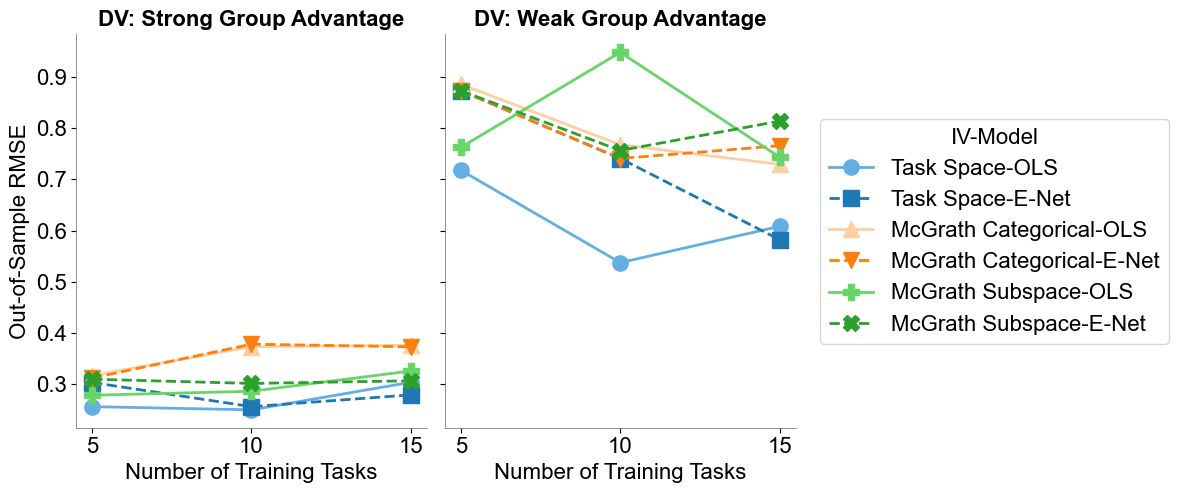

In [28]:
plot_model_comparison(df_plot_rmse, ["Task Space", "McGrath Categorical", "McGrath Subspace"], "RMSE")

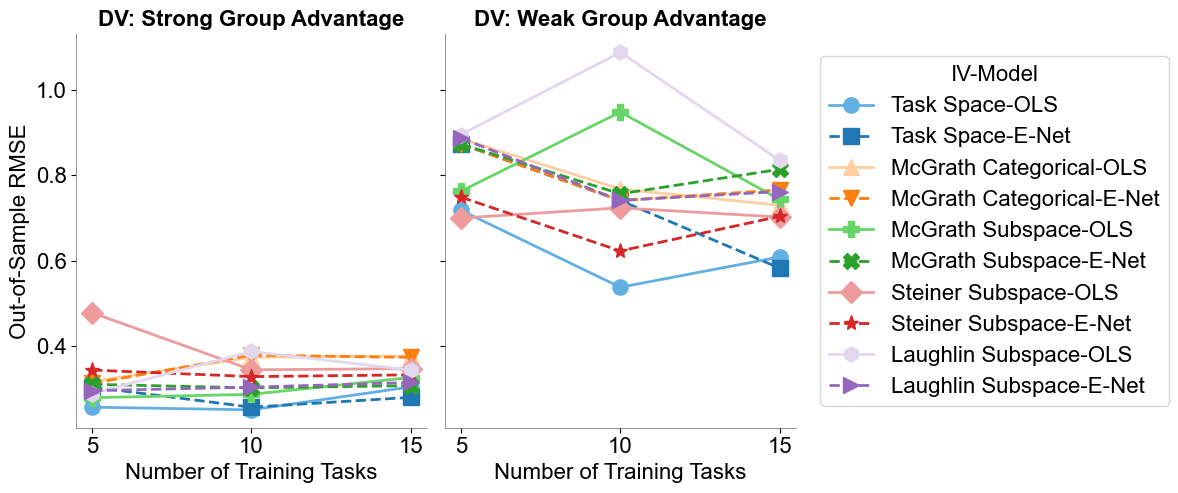

In [29]:
plot_model_comparison(df_plot_rmse, ["Task Space", "McGrath Categorical", "McGrath Subspace", "Steiner Subspace", "Laughlin Subspace"], "RMSE")

### R^2 Version

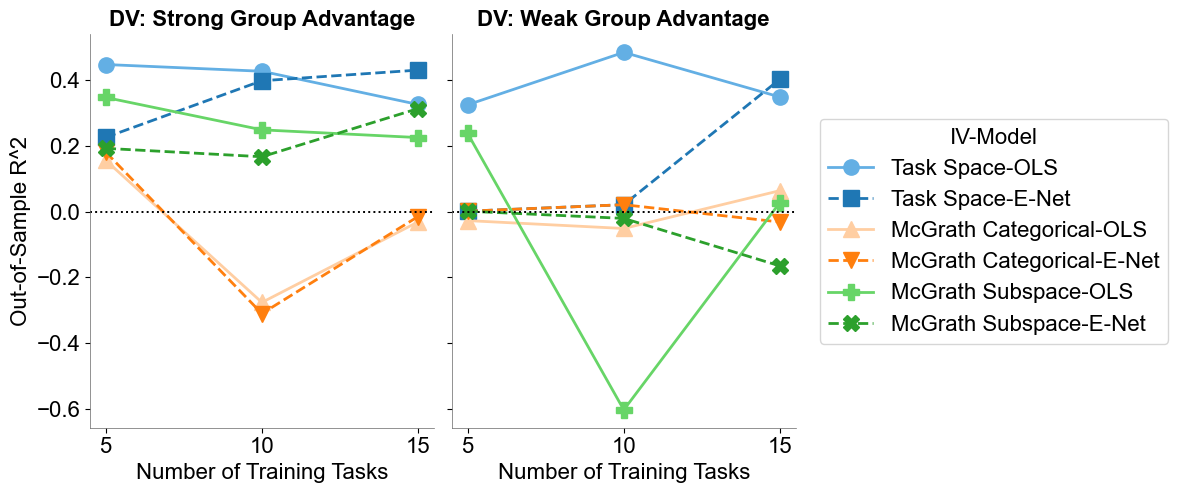

In [30]:
plot_model_comparison(df_plot_r2, ["Task Space", "McGrath Categorical", "McGrath Subspace"], "R^2")

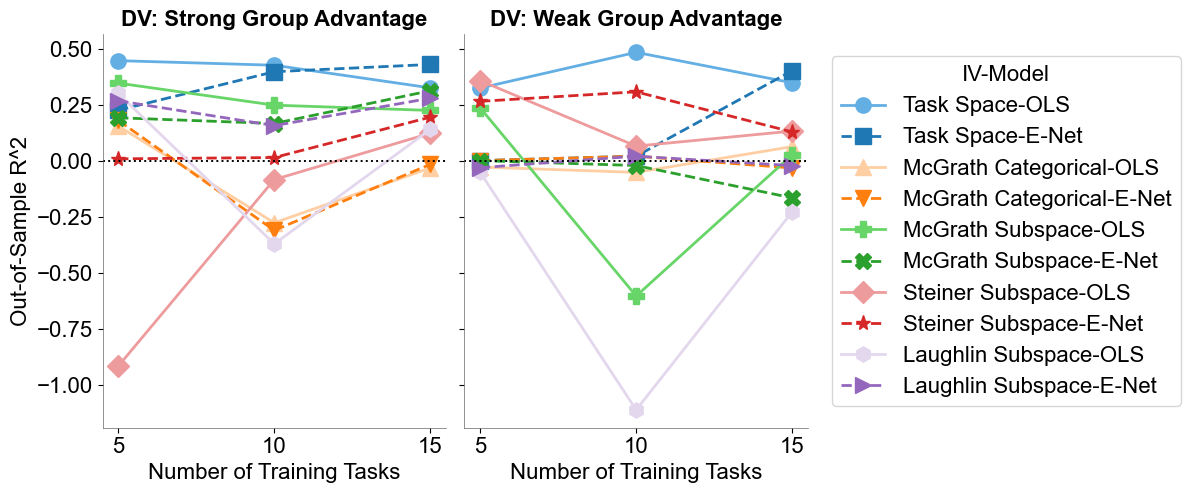

In [31]:
plot_model_comparison(df_plot_r2, ["Task Space", "McGrath Categorical", "McGrath Subspace", "Steiner Subspace", "Laughlin Subspace"], "R^2")

## Model Scatterplot

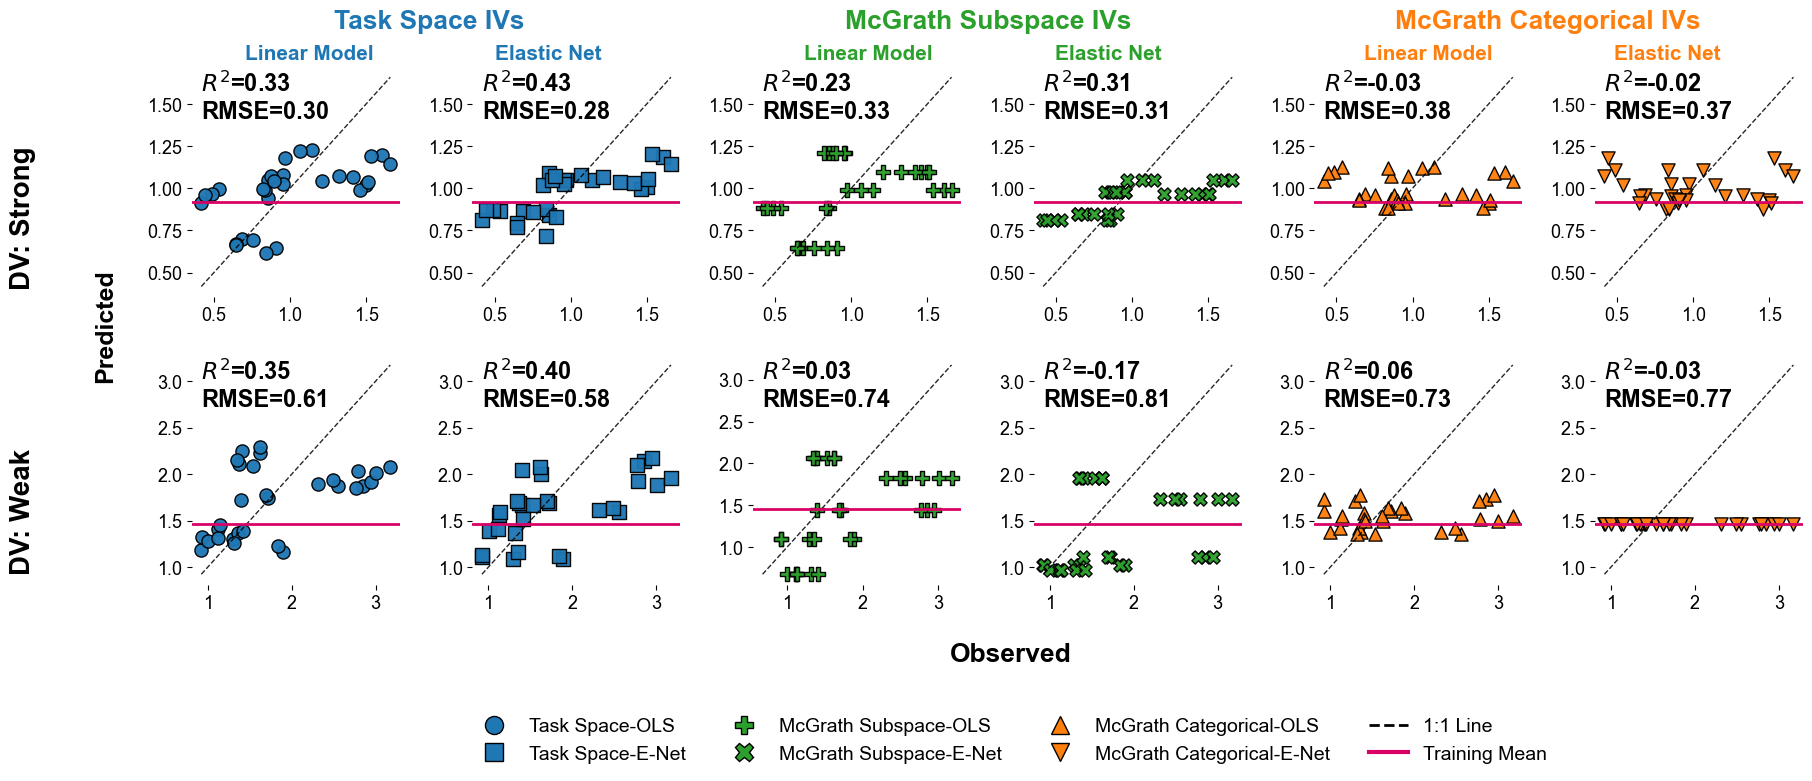

In [36]:
def plot_group_advantage_pred_vs_obs_strong_weak(
    MODELS, wave, DATA, custom_r2, ivs_selected,
    get_rmse_ols, get_rmse_for_enet
):
    fallback_color = "#888"
    fallback_marker = "o"
    models = ["OLS", "E-Net"]
    dvs = ["strong", "weak"]
    ms=90

    # Create subplots with 2 rows and 2*N columns (N = number of IVs selected)
    fig,axes=plt.subplots(2,len(ivs_selected)*2,figsize=(len(ivs_selected)*6,7))

    # dfs for export
    model_info_list = []

    # Main plotting loop
    for r,dv in enumerate(dvs):
        for i,iv in enumerate(ivs_selected):
            if iv not in base_palette: base_palette[iv] = fallback_color
            if f"{iv}-OLS" not in marker_dict: marker_dict[f"{iv}-OLS"] = fallback_marker
            if f"{iv}-E-Net" not in marker_dict: marker_dict[f"{iv}-E-Net"] = fallback_marker

            # get correct ivs list
            if iv=="Task Space": ivs = basic_IVs
            elif iv=="McGrath Categorical": ivs = categorical_IVs
            elif iv=="McGrath Subspace": ivs = mcgrath_continuous
            elif iv=="Steiner Subspace": ivs = steiner_continuous
            elif iv=="Laughlin Subspace": ivs = laughlin_continuous
            else: raise ValueError(f"Unknown IV type: {iv}")

            m_ols = MODELS[iv]["OLS"][wave][dv]
            m_enet = MODELS[iv]["E-Net"][wave][dv]
            Xtest_all = DATA[wave]["test"]
            y = Xtest_all[dv].values
            ytr = DATA[wave]["train"][dv].mean()
            # Make X_test for each model
            X_ols = sm.add_constant(Xtest_all[ivs],has_constant='add')
            X_enet = add_interactions(Xtest_all[ivs])
            for j,m in enumerate(models):
                c = i*2+j
                ax = axes[r,c]
                mdl = m_ols if m=="OLS" else m_enet
                X = X_ols if m=="OLS" else X_enet
                try:
                    # Ensure X matches training columns!
                    if hasattr(mdl,"model") and hasattr(mdl.model,"exog_names"):
                        needed_cols = mdl.model.exog_names
                        X = X.reindex(columns=needed_cols, fill_value=0)
                    yhat = mdl.predict(X) if hasattr(mdl,'predict') else mdl(X)
                    if hasattr(yhat,'flatten'): yhat = yhat.flatten()
                except Exception as e:
                    ax.set_xticks([]); ax.set_yticks([]);
                    ax.set_facecolor("#F6F6F6")
                    continue

                rmse = get_rmse_ols(m_ols,Xtest_all,y,ivs) if m=="OLS" else get_rmse_for_enet(m_enet,Xtest_all,y,ivs)
                r2 = custom_r2(yhat,y,DATA[wave]['train'],DATA[wave]['test'],dv)
                color=base_palette[iv]
                marker=marker_dict[f"{iv}-{m}"]

                # export information about this model
                model_info = {
                    "iv": iv,
                    "dv": dv,
                    "model": m,
                    "y_pred": yhat,
                    "y_actual": y,
                    "rmse": rmse,
                    "r2": r2
                }
                model_info_list.append(pd.DataFrame(model_info))

                ax.scatter(y,yhat,color=color,marker=marker,s=ms,edgecolor="k",alpha=.96)
                mi,ma=min(np.min(y),np.min(yhat)),max(np.max(y),np.max(yhat))
                ax.plot([mi,ma],[mi,ma],'k--',lw=1,alpha=.85)
                ax.axhline(ytr,color='#D90368',lw=2)
                ax.text(.045,.98,f"$R^2$={r2:.2f}\nRMSE={rmse:.2f}",
                        ha="left",va="top",transform=ax.transAxes,fontsize=17,fontweight="bold")
                ax.tick_params(axis="x",labelsize=13)
                ax.tick_params(axis="y",labelsize=13)
                [sp.set_visible(False) for sp in ax.spines.values()]
                ax.set_facecolor('white')

    # Side labels
    for row,dv in enumerate(dvs):
        p=axes[row,0].get_position();ym=p.y0+p.height/2
        fig.text(.0085,ym,f'DV: {"Strong" if dv=="strong" else "Weak"}',va="center",ha="right",rotation=90,fontsize=20,fontweight="bold")

    # Center group/IV and model labels
    buffer = 0.045 * (3/len(ivs_selected))  # Adjust buffer based on number of IVs
    left_offset = 0.02
    for i, iv in enumerate(ivs_selected):
        c0, c1 = i*2, i*2+1
        ax_l, ax_r = axes[0, c0], axes[0, c1]
        # Just add i*buffer, nothing else:
        xm_iv = (ax_l.get_position().x0 + ax_r.get_position().x1)/2 + i*buffer - left_offset
        fig.text(xm_iv, .975, f"{iv} IVs", ha="center", fontsize=19, fontweight="bold", color=base_palette[iv])
        x_l = (ax_l.get_position().x0 + ax_l.get_position().x1)/2 + i*buffer - left_offset
        x_r = (ax_r.get_position().x0 + ax_r.get_position().x1)/2 + i*buffer - left_offset
        fig.text(x_l, .93, "Linear Model",  color=base_palette[iv], fontsize=15, fontweight="bold", ha="center")
        fig.text(x_r, .93, "Elastic Net",   color=base_palette[iv], fontsize=15, fontweight="bold", ha="center")

    # Observed/Predicted labels
    fig.text(.047,.55,"Predicted",ha='center',va='center',rotation=90,fontsize=18,fontweight="bold")
    fig.text(.55,.08,"Observed",ha="center",va="center",fontsize=19,fontweight="bold")

    plt.subplots_adjust(wspace=0.35, hspace=0.25, right=0.99, top=0.92, left=0.095, bottom=0.18)

    le=[]
    for iv in ivs_selected:
        for m in models:
            le.append(Line2D([0],[0],marker=marker_dict[f"{iv}-{m}"],color=base_palette[iv],
                markerfacecolor=base_palette[iv],markeredgecolor='k',markersize=13,linestyle='None',label=f"{iv}-{m}"))
    le.append(Line2D([0],[0],color='k',label='1:1 Line',linestyle='--',lw=2))
    le.append(Line2D([0],[0],color='#D90368',label='Training Mean',linestyle='-',lw=3))

    fig.legend(handles=le,loc='lower center',fontsize=14,ncol=len(le)/2,bbox_to_anchor=(0.55,-.1),frameon=False)
    
    pd.concat(model_info_list).to_csv(f'../outputs/scatterplot_model_info_raw__{wave}_{len(ivs_selected)}.csv')

    plt.savefig(f"../outputs/group_advantage_pred_vs_obs_{wave}_{len(ivs_selected)}_models.png",bbox_inches='tight',dpi=300)
    plt.savefig(f"../outputs/group_advantage_pred_vs_obs_{wave}_{len(ivs_selected)}_models.pdf",bbox_inches='tight',dpi=300)
    plt.show()

plot_group_advantage_pred_vs_obs_strong_weak(MODELS, "Wave 2", TRAIN_TEST_DATA, custom_r2,
                                             ["Task Space", "McGrath Subspace", "McGrath Categorical"], get_rmse_ols, get_rmse_for_enet)

Version with all models

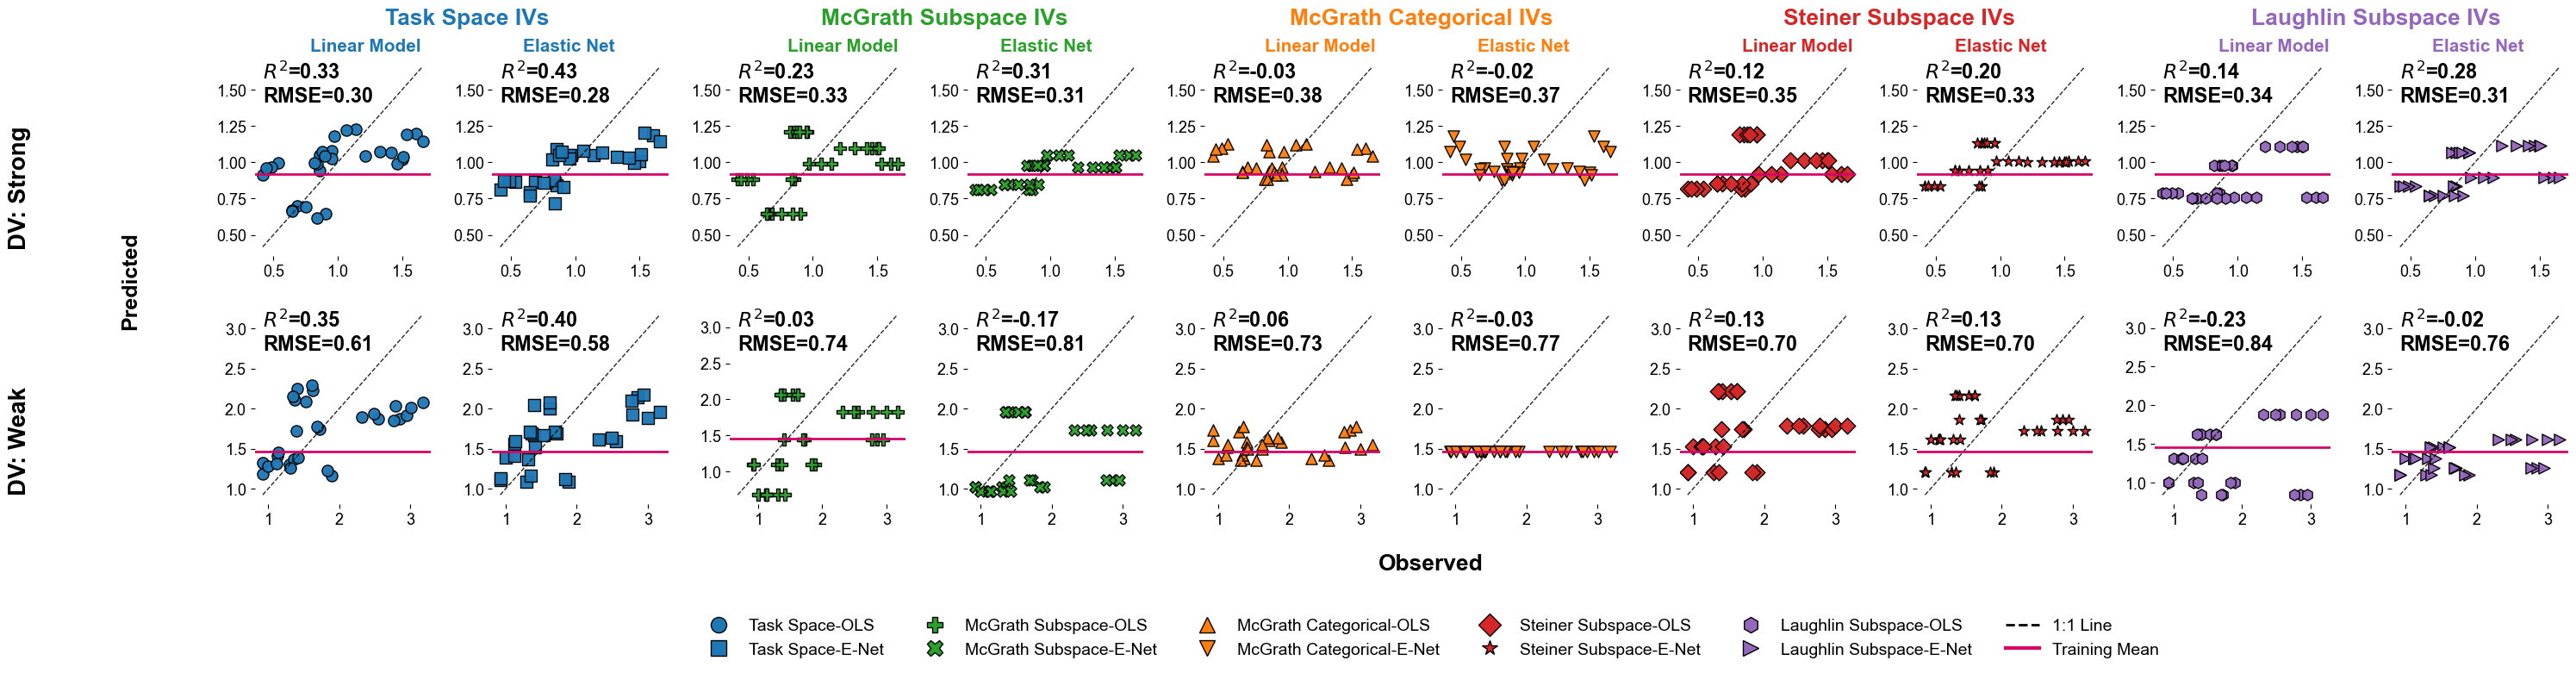

In [37]:
plot_group_advantage_pred_vs_obs_strong_weak(MODELS, "Wave 2", TRAIN_TEST_DATA, custom_r2,
                                             ["Task Space", "McGrath Subspace", "McGrath Categorical", "Steiner Subspace", "Laughlin Subspace"],
                                             get_rmse_ols, get_rmse_for_enet)

## Bootstrapped Robustness Checks

In [19]:
def analyze_bootstrap_r2_boxplot(bootstrapped_r2_results, plt_title, dv_choice, xlim_min = -5, xlim_max = 1.05, xlab = '$R^2$'):
    if dv_choice not in ['strong', 'weak']:
        raise ValueError("Invalid DV type. Please choose 'strong' or 'weak'.")

    plot_data = []
    for iv_type, models in bootstrapped_r2_results.items():
        for model_type, dv_types in models.items():
            r2_values = dv_types.get(dv_choice, [])
            if r2_values:
                for r2 in np.atleast_1d(r2_values):
                    plot_data.append({
                        'IV Type': iv_type,
                        'Model Type': f"{iv_type} - {model_type} - {dv_choice}",
                        'Model': model_type,
                        'R2': r2
                    })

    df_plot = pd.DataFrame(plot_data)

    color_dict = {}
    for iv in base_palette.keys():
        for model in ["OLS", "E-Net"]:
            for dv in ["strong", "weak"]:
                k = f"{iv} - {model} - {dv}"
                c = get_color(iv, model)
                color_dict[k] = c

    iv_order = list(reversed(list(base_palette.keys())))

    g = sns.FacetGrid(
        df_plot, 
        col="IV Type", 
        col_wrap=1, 
        sharex=False, 
        sharey=False, 
        height=3.6, 
        aspect=1.5, 
        margin_titles=True
    )

    g.map_dataframe(
        sns.boxplot,
        x="R2",
        y='Model',
        hue='Model Type',
        hue_order=df_plot['Model Type'].unique(),
        palette=color_dict,
        fliersize=2,
        linewidth=1,
        width=0.6,
        medianprops={'linewidth': 3} 
    )

    g.set_titles('{col_name}', size=16)
    g.set_axis_labels(xlab, '', fontsize=16)
    g.set(xlim=(xlim_min, xlim_max))
    g.despine(left=True)

    for ax in g.axes.flatten():
        ax.axvline(0, color='black', linestyle='--', linewidth=2, alpha=0.7)
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)

    g.fig.supylabel('Model', fontsize=20, x=0.02)

    plt.subplots_adjust(top=0.85, hspace=0.4)
    g.fig.set_size_inches(10, 15)
    g.fig.suptitle(f"{plt_title} {dv_choice.capitalize()} Group Advantage", fontsize=20, y=0.9, fontweight='bold')

    plt.savefig(f"../outputs/bootstrapped_r2_boxplot_{plt_title}_{dv_choice}.png", dpi=300, bbox_inches='tight')
    plt.savefig(f"../outputs/bootstrapped_r2_boxplot_{plt_title}_{dv_choice}.pdf", dpi=300, bbox_inches='tight')
    plt.show()
    
    results = {}
    for model_type in ["OLS", "E-Net"]:
        results[model_type] = {}
        iv_types = list(bootstrapped_r2_results.keys())
        for i, iv_1 in enumerate(iv_types):
            if not bootstrapped_r2_results[iv_1][model_type].get(dv_choice, []):
                continue
            for iv_2 in iv_types[i+1:]:
                if not bootstrapped_r2_results[iv_2][model_type].get(dv_choice, []):
                    continue
                data1 = bootstrapped_r2_results[iv_1][model_type][dv_choice]
                data2 = bootstrapped_r2_results[iv_2][model_type][dv_choice]
                if data1 and data2:
                    t_stat, p_value = stats.ttest_ind(data1, data2, nan_policy='omit')
                    results[model_type][f"{iv_1} vs {iv_2} - {dv_choice}"] = (format_value(t_stat), format_p_value(p_value))

    for model_type, comparisons in results.items():
        print(f"\n{model_type}")
        for comparison, (t_statistic, p_value) in comparisons.items():
            direction = "up" if float(t_statistic) > 0 else "down"
            print(f"{comparison}: t-statistic = {t_statistic} ({direction}), p-value = {p_value}")

def format_value(value):
    if pd.isna(value) or value is None:
        return np.nan
    if abs(value) > 5:
        return np.format_float_scientific(value, precision=4)
    return np.round(value, 4)

def format_p_value(p_value):
    if pd.isna(p_value) or p_value is None:
        return np.nan
    if p_value < 0.001:
        return np.format_float_scientific(p_value, precision=4)
    return np.round(p_value, 4)

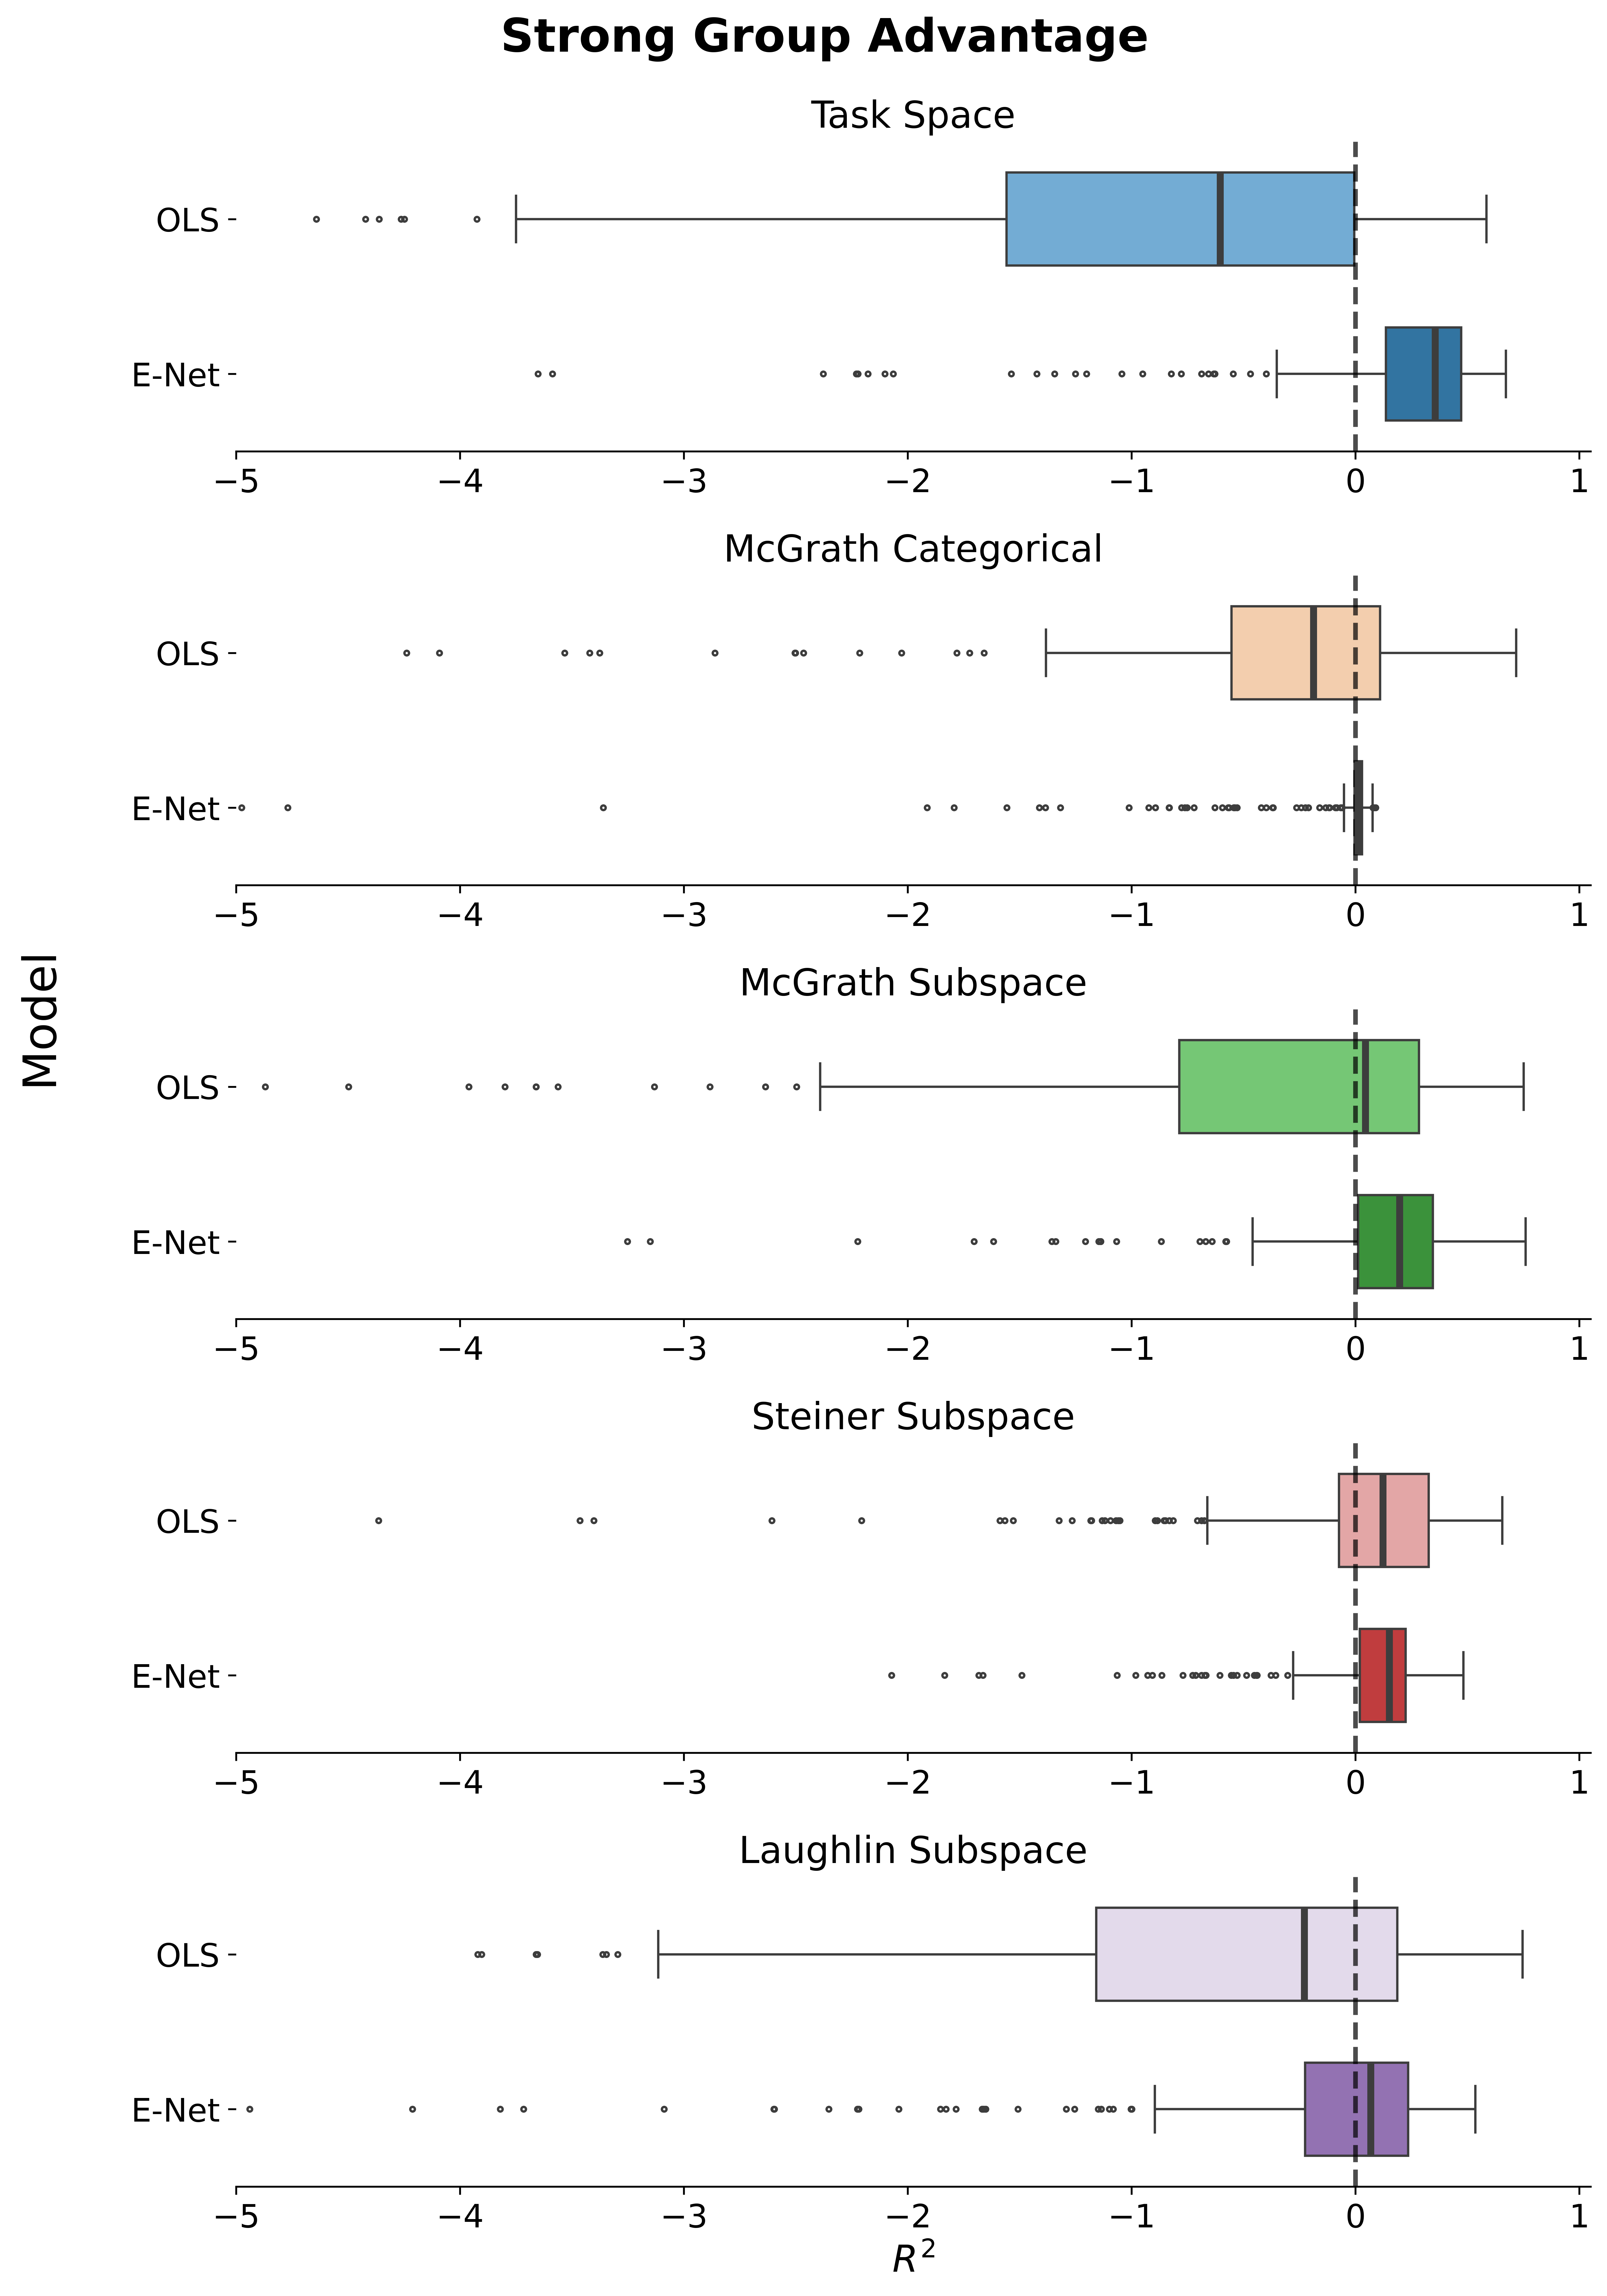


OLS
Task Space vs McGrath Categorical - strong: t-statistic = -5.5667e+00 (down), p-value = 4.2491e-08
Task Space vs McGrath Subspace - strong: t-statistic = -3.4098 (down), p-value = 7.0299e-04
Task Space vs Steiner Subspace - strong: t-statistic = -6.8872e+00 (down), p-value = 1.7221e-11
Task Space vs Laughlin Subspace - strong: t-statistic = -1.9214 (down), p-value = 0.0552
McGrath Categorical vs McGrath Subspace - strong: t-statistic = 2.2644 (up), p-value = 0.024
McGrath Categorical vs Steiner Subspace - strong: t-statistic = -3.6139 (down), p-value = 3.3225e-04
McGrath Categorical vs Laughlin Subspace - strong: t-statistic = 3.6063 (up), p-value = 3.4195e-04
McGrath Subspace vs Steiner Subspace - strong: t-statistic = -4.1924 (down), p-value = 3.2671e-05
McGrath Subspace vs Laughlin Subspace - strong: t-statistic = 1.4556 (up), p-value = 0.1461
Steiner Subspace vs Laughlin Subspace - strong: t-statistic = 5.1625e+00 (up), p-value = 3.5277e-07

E-Net
Task Space vs McGrath Categor

In [20]:
analyze_bootstrap_r2_boxplot(BOOTSTRAP_R2_RESULTS, "", "strong")

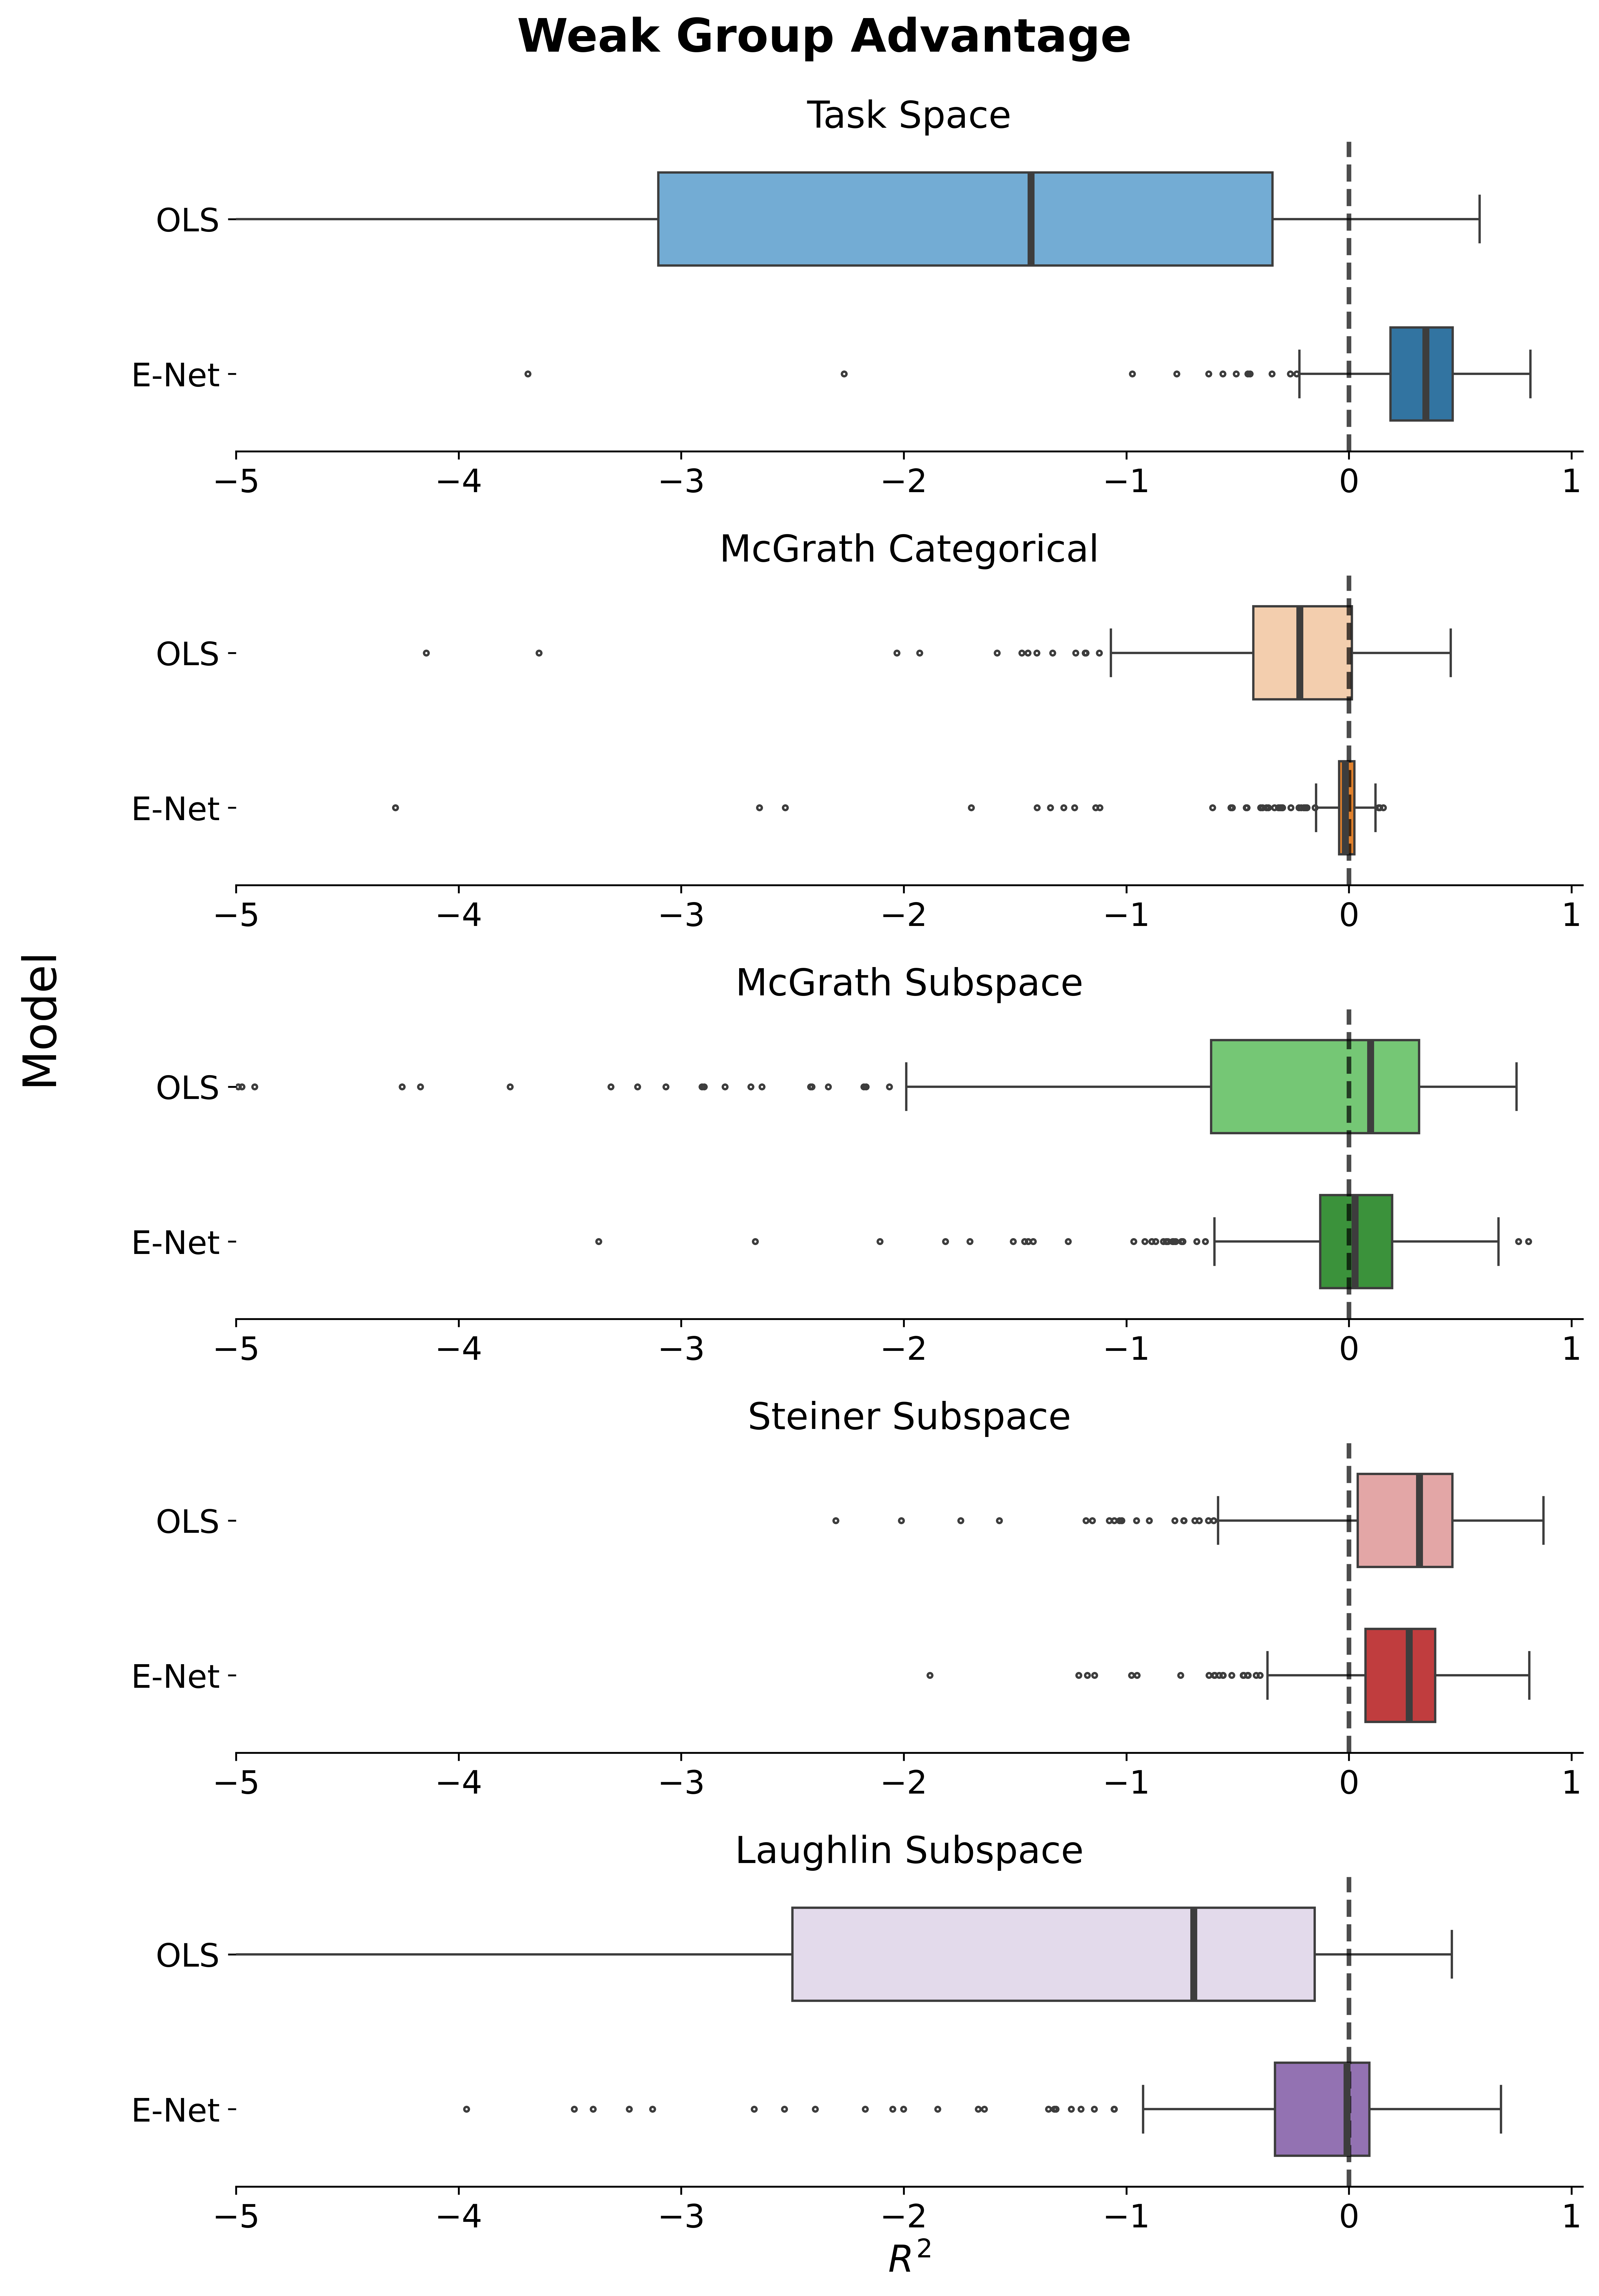


OLS
Task Space vs McGrath Categorical - weak: t-statistic = -1.0342e+01 (down), p-value = 7.7250e-23
Task Space vs McGrath Subspace - weak: t-statistic = -6.0388e+00 (down), p-value = 3.04e-09
Task Space vs Steiner Subspace - weak: t-statistic = -1.2668e+01 (down), p-value = 4.4827e-32
Task Space vs Laughlin Subspace - weak: t-statistic = 1.3322 (up), p-value = 0.1834
McGrath Categorical vs McGrath Subspace - weak: t-statistic = 2.784 (up), p-value = 0.0056
McGrath Categorical vs Steiner Subspace - weak: t-statistic = -1.0828e+01 (down), p-value = 1.1138e-24
McGrath Categorical vs Laughlin Subspace - weak: t-statistic = 7.5795e+00 (up), p-value = 1.7078e-13
McGrath Subspace vs Steiner Subspace - weak: t-statistic = -5.4404e+00 (down), p-value = 8.3483e-08
McGrath Subspace vs Laughlin Subspace - weak: t-statistic = 5.5197e+00 (up), p-value = 5.4730e-08
Steiner Subspace vs Laughlin Subspace - weak: t-statistic = 8.9355e+00 (up), p-value = 7.8890e-18

E-Net
Task Space vs McGrath Categori

In [21]:
analyze_bootstrap_r2_boxplot(BOOTSTRAP_R2_RESULTS, "", "weak")

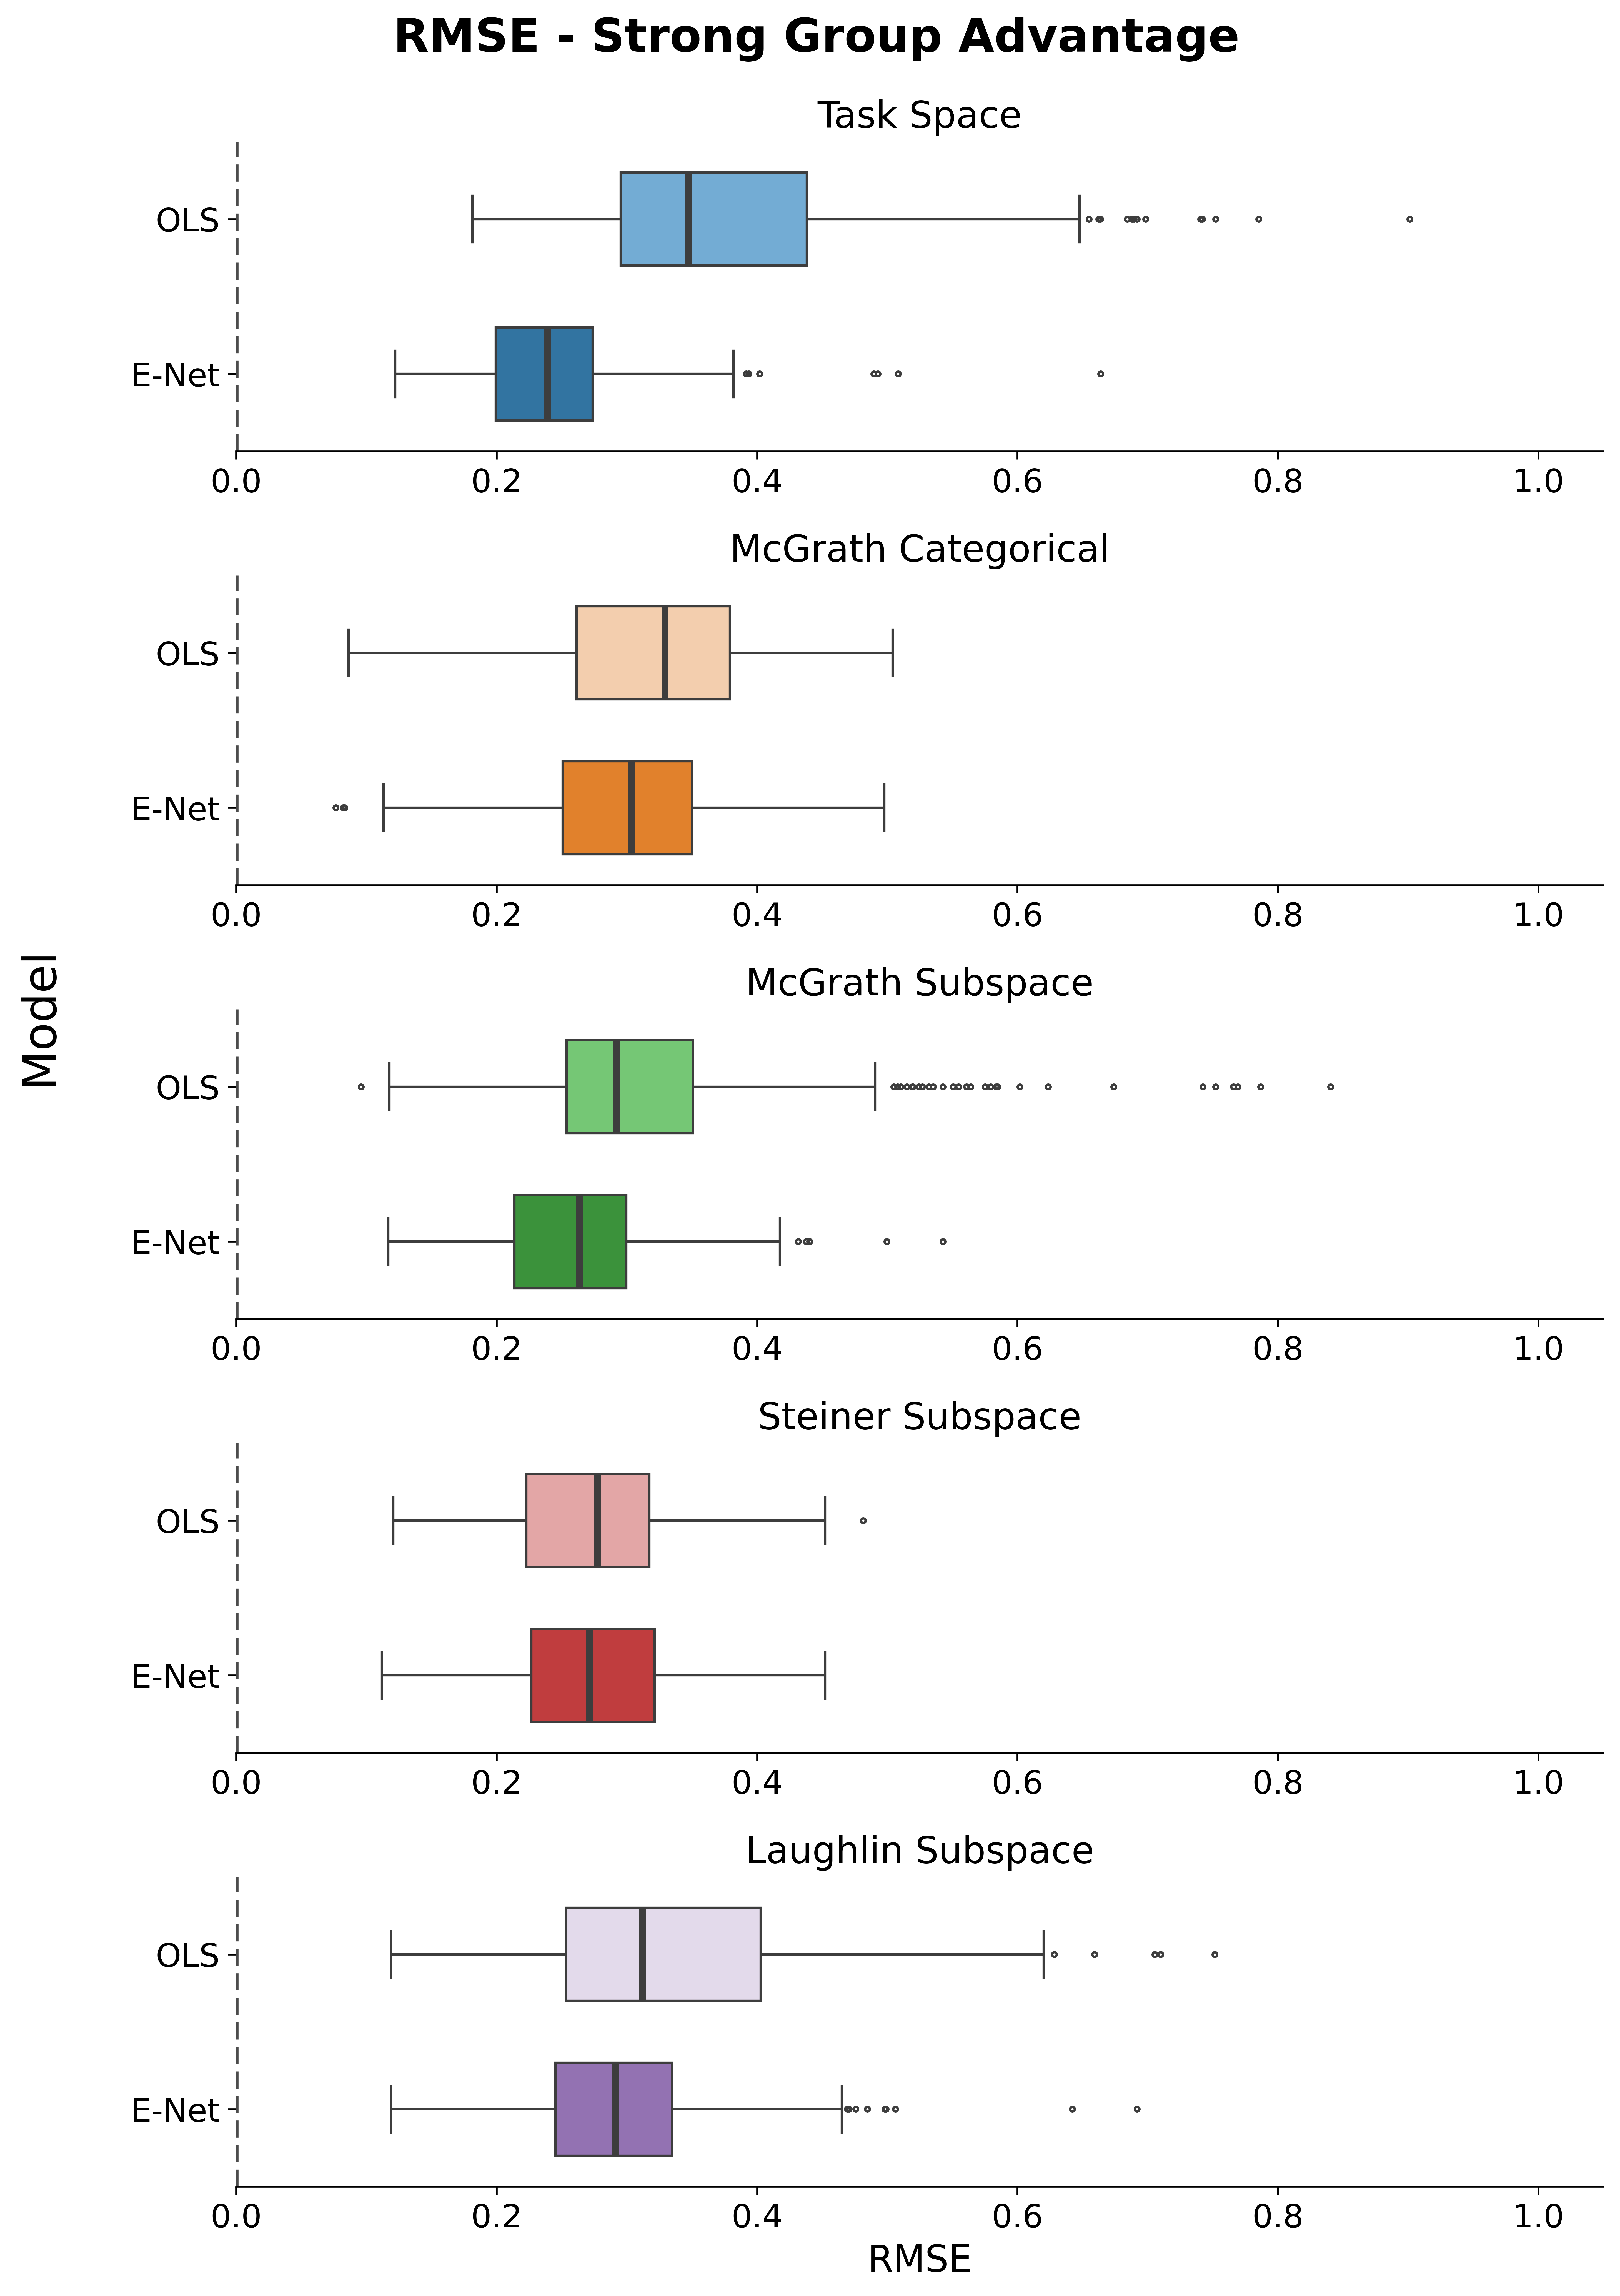


OLS
Task Space vs McGrath Categorical - strong: t-statistic = 6.6487e+00 (up), p-value = 7.7894e-11
Task Space vs McGrath Subspace - strong: t-statistic = 5.7241e+00 (up), p-value = 1.7989e-08
Task Space vs Steiner Subspace - strong: t-statistic = 1.2088e+01 (up), p-value = 1.1226e-29
Task Space vs Laughlin Subspace - strong: t-statistic = 4.0758 (up), p-value = 5.3371e-05
McGrath Categorical vs McGrath Subspace - strong: t-statistic = -0.0215 (down), p-value = 0.9829
McGrath Categorical vs Steiner Subspace - strong: t-statistic = 6.5457e+00 (up), p-value = 1.4754e-10
McGrath Categorical vs Laughlin Subspace - strong: t-statistic = -2.2605 (down), p-value = 0.0242
McGrath Subspace vs Steiner Subspace - strong: t-statistic = 5.1233e+00 (up), p-value = 4.3005e-07
McGrath Subspace vs Laughlin Subspace - strong: t-statistic = -1.8986 (down), p-value = 0.0582
Steiner Subspace vs Laughlin Subspace - strong: t-statistic = -7.8523e+00 (down), p-value = 2.5271e-14

E-Net
Task Space vs McGrath 

In [22]:
analyze_bootstrap_r2_boxplot(BOOTSTRAP_RMSE_RESULTS, "RMSE -", "strong", xlim_min=0, xlab = "RMSE")

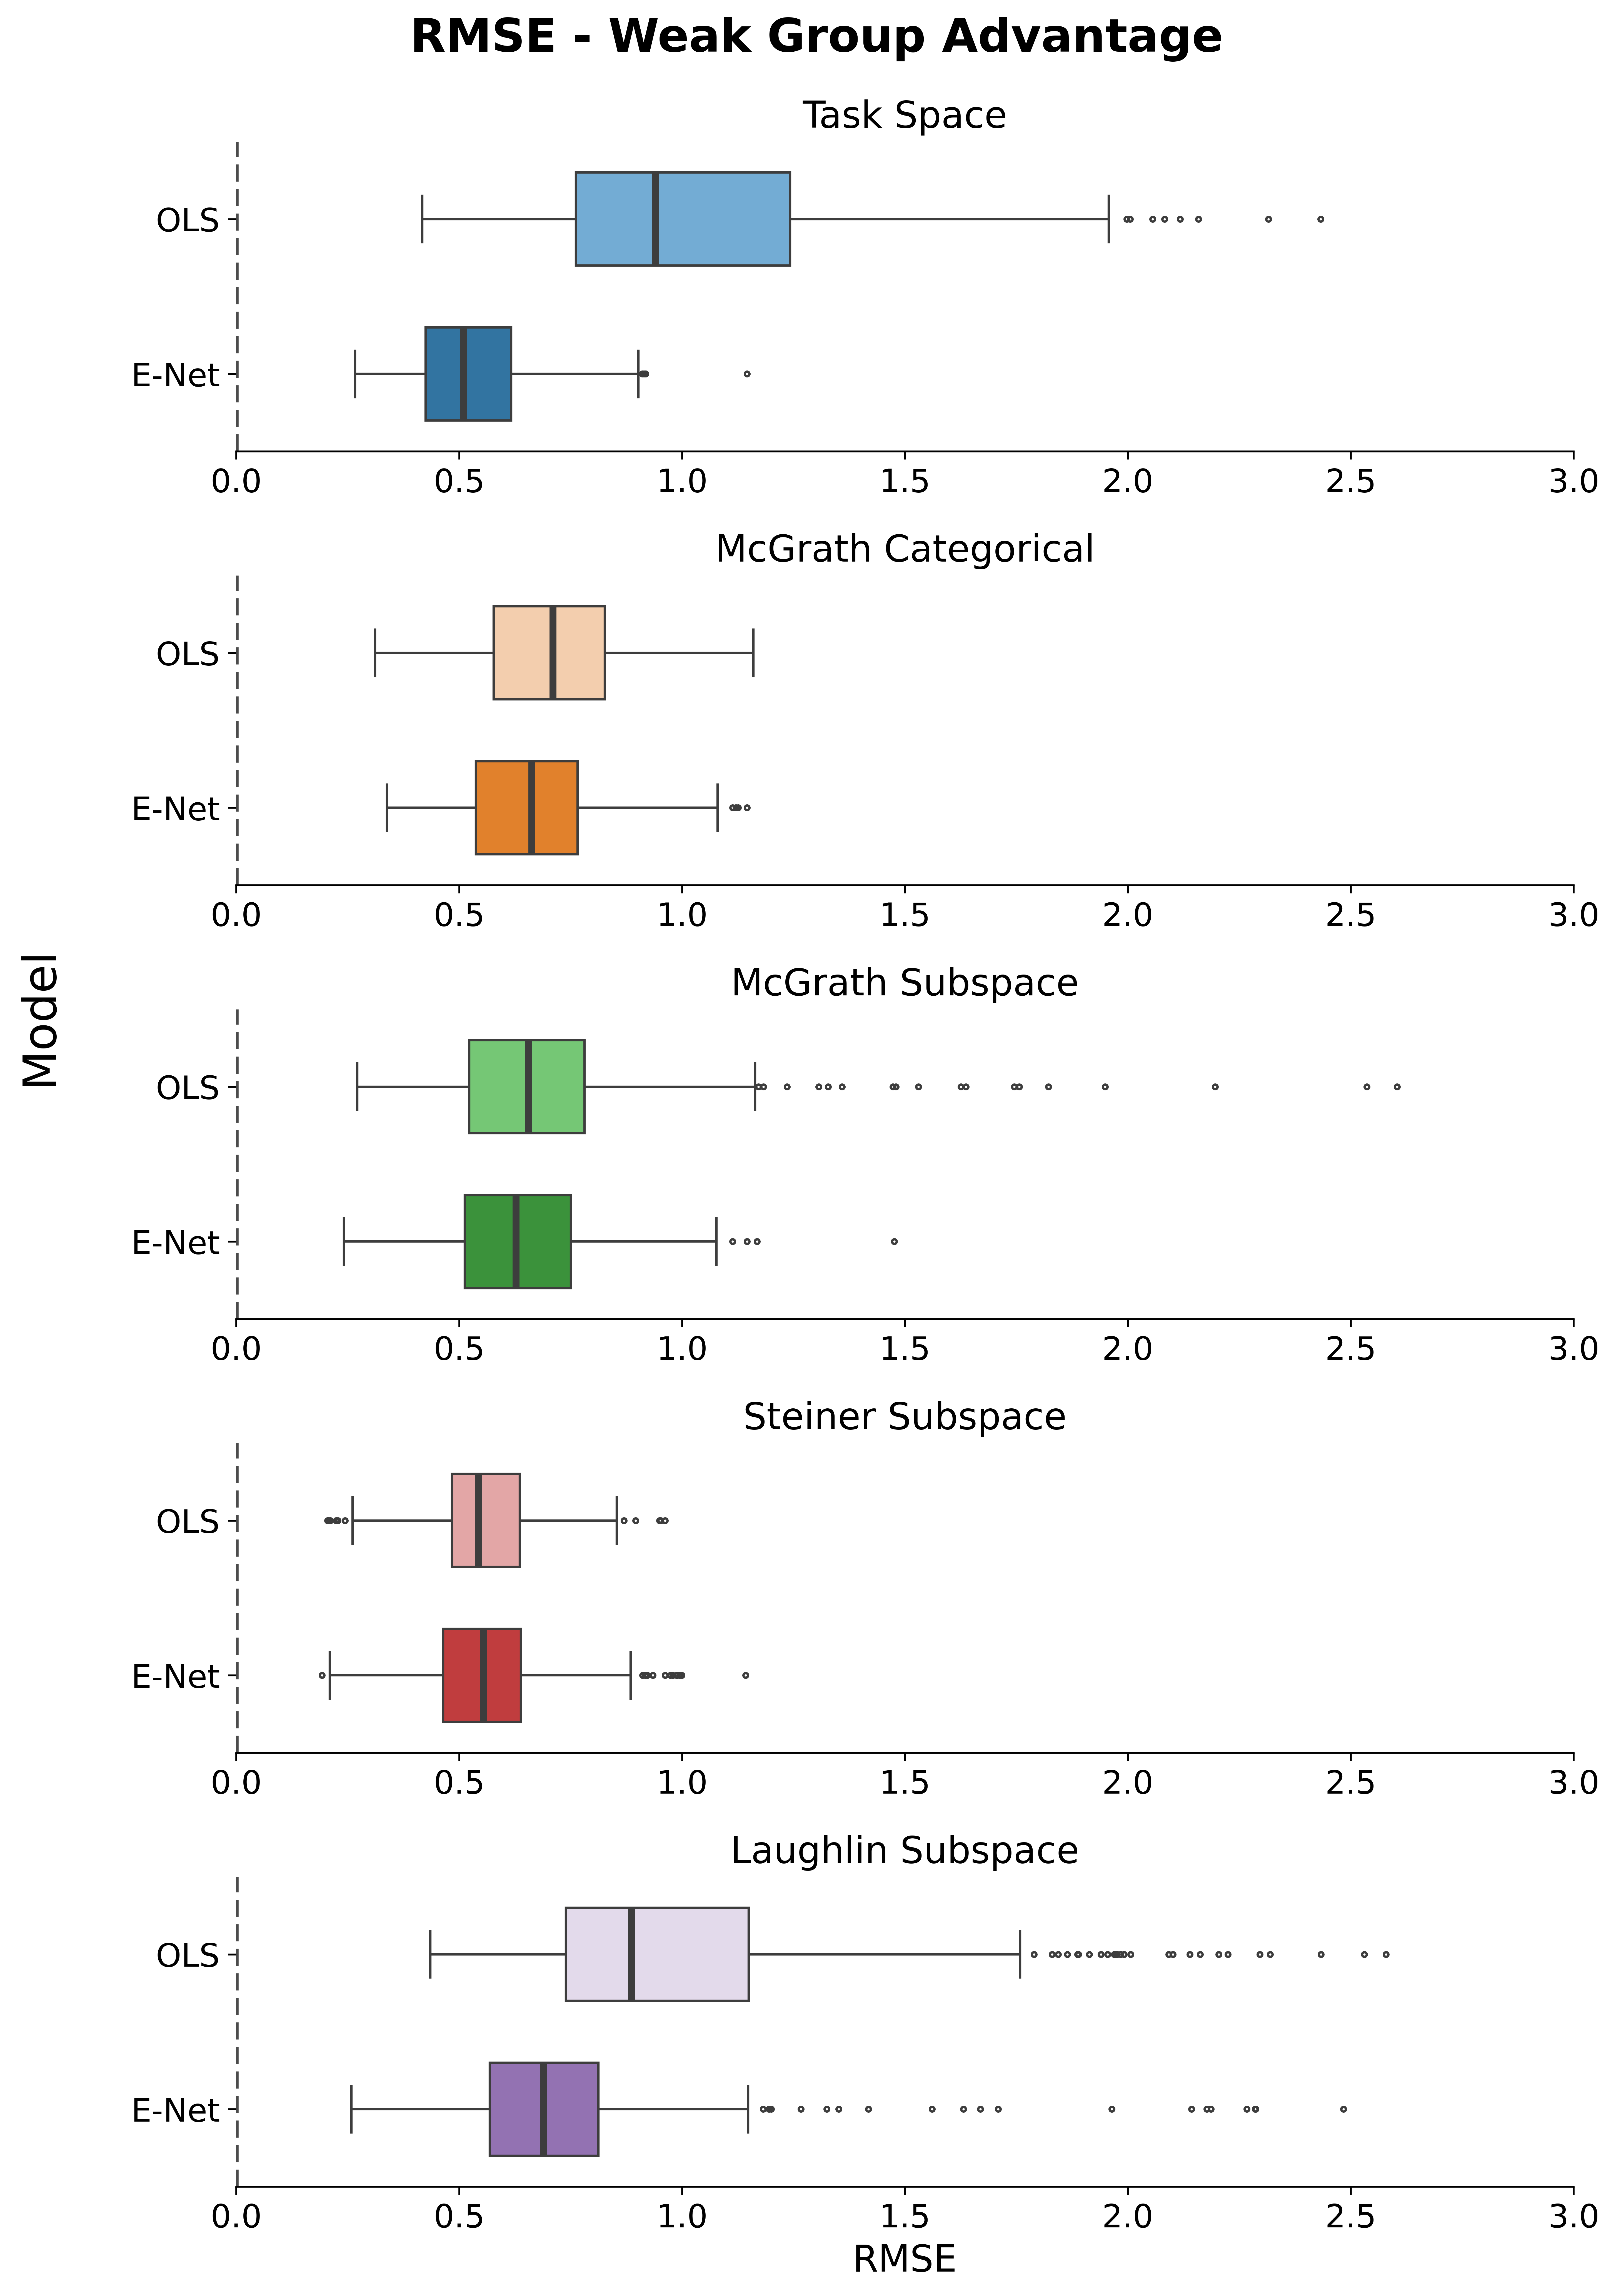


OLS
Task Space vs McGrath Categorical - weak: t-statistic = 1.2409e+01 (up), p-value = 5.3442e-31
Task Space vs McGrath Subspace - weak: t-statistic = 1.0247e+01 (up), p-value = 1.7365e-22
Task Space vs Steiner Subspace - weak: t-statistic = 1.9501e+01 (up), p-value = 2.3851e-63
Task Space vs Laughlin Subspace - weak: t-statistic = 0.3098 (up), p-value = 0.7569
McGrath Categorical vs McGrath Subspace - weak: t-statistic = 0.0388 (up), p-value = 0.9691
McGrath Categorical vs Steiner Subspace - weak: t-statistic = 1.2003e+01 (up), p-value = 2.4859e-29
McGrath Categorical vs Laughlin Subspace - weak: t-statistic = -1.0105e+01 (down), p-value = 5.8139e-22
McGrath Subspace vs Steiner Subspace - weak: t-statistic = 7.356e+00 (up), p-value = 7.8623e-13
McGrath Subspace vs Laughlin Subspace - weak: t-statistic = -8.7593e+00 (down), p-value = 3.0849e-17
Steiner Subspace vs Laughlin Subspace - weak: t-statistic = -1.593e+01 (down), p-value = 1.7966e-46

E-Net
Task Space vs McGrath Categorical -

In [23]:
analyze_bootstrap_r2_boxplot(BOOTSTRAP_RMSE_RESULTS, "RMSE -", "weak", xlim_min=0, xlim_max=3, xlab = "RMSE")

## Permutation/SHAP Interpretation Plots

In [24]:
def model_predict(fitted_model, X, model_type):
    if model_type == "LM":
        X = sm.add_constant(X, has_constant='add')
        return fitted_model.predict(X)
    elif model_type == "NN":
        return fitted_model.predict(X).flatten()
    elif model_type == "E-Net":
        X = add_interactions(X)
        return fitted_model.predict(X)

In [25]:
def plot_combined_feature_importance(
    model, wave_a_data, wave_b_data, ivs, dv_type, model_type, 
    save_path='./visualizations/combined_importance.png', n_repeats=100):
    
    set_random_seeds()

    X_test = wave_b_data[ivs].copy()
    y_test = wave_b_data[dv_type].values
    y_pred = model_predict(model, X_test, model_type)
    base_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Map features to their groups using the provided dictionary
    feature_to_group = {}
    for key, group_name in pretty_feature_cluster_names.items():
        try:
            feature_list = ast.literal_eval(key)
            features = feature_list if isinstance(feature_list, list) else [feature_list]
        except (ValueError, SyntaxError):
            features = [key]
        for feature in features:
            feature_to_group[feature] = group_name

    # Create a mapping from groups to features
    group_to_features = {}
    for feature in ivs:
        group_name = feature_to_group.get(feature, feature)
        group_to_features.setdefault(group_name, []).append(feature)
        feature_to_group[feature] = group_name

    groups = list(group_to_features.keys())
    importances = np.zeros(len(groups))
    conf_intervals = np.zeros(len(groups))

    # Calculate permutation feature importance for each group
    for i, group_name in enumerate(groups):
        features_in_group = group_to_features[group_name]
        scores = np.zeros(n_repeats)
        for n in range(n_repeats):
            X_permuted = X_test.copy()
            permutation = np.random.permutation(len(X_test))
            for feature in features_in_group:
                X_permuted[feature] = X_permuted[feature].values[permutation]
            y_permuted_pred = model_predict(model, X_permuted, model_type)
            permuted_rmse = np.sqrt(mean_squared_error(y_test, y_permuted_pred))
            scores[n] = ((permuted_rmse - base_rmse) / base_rmse) * 100
        importances[i] = scores.mean()
        conf_intervals[i] = 1.96 * scores.std(ddof=1) / np.sqrt(n_repeats)

    exclude_groups = ["Generate", "High", "Medium", "Low", "playerCount"]
    display_indices = [i for i, group_name in enumerate(groups) if group_name not in exclude_groups]
    importances_display = importances[display_indices]
    conf_intervals_display = conf_intervals[display_indices]
    groups_display = [groups[i] for i in display_indices]

    sorted_indices = np.argsort(importances_display)
    sorted_group_names = np.array(groups_display)[sorted_indices]
    importances_sorted = importances_display[sorted_indices]
    conf_intervals_sorted = conf_intervals_display[sorted_indices]
    
    # Configure matplotlib for the desired style
    plt.style.use('default')
    matplotlib.rcParams.update({
        'figure.figsize': (7.2, 4.72),
        'font.size': 9,
        'font.sans-serif': ['Arial'],
        'axes.facecolor': 'white',
        'axes.edgecolor': '#666666',
        'axes.linewidth': 0.5,
        'grid.alpha': 0.0,
        'pdf.fonttype': 42,
        'ps.fonttype': 42
    })
    
    # Define the figure and grid specs for the plots
    fig = plt.figure(figsize=(7.2, 4.72), dpi=300)
    gs = plt.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.2)
    ax_left = fig.add_subplot(gs[0])
    ax_right = fig.add_subplot(gs[1], sharey=ax_left)  # Use sharey for alignment

    # Left plot
    ax_left.barh(
        range(len(sorted_group_names)),
        importances_sorted,
        xerr=conf_intervals_sorted,
        align='center',
        alpha=0.7,
        capsize=3,
        height=0.5,
        color='#2166AC',
        edgecolor='k'
    )
    ax_left.set_yticks(range(len(sorted_group_names)))
    ax_left.set_yticklabels(sorted_group_names)
    ax_left.invert_yaxis()
    ax_left.set_xlabel("Feature Importance\n(% Change in RMSE)", fontsize=10)
    ax_left.axvline(x=0, linestyle='--', color='#666666', linewidth=0.8, zorder=0)
    ax_left.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    # Remove top and right spines
    ax_left.spines['top'].set_visible(False)
    ax_left.spines['right'].set_visible(False)

    # Adjust tick parameters
    ax_left.tick_params(axis='both', which='major', labelsize=9, length=3, width=0.5)
    ax_left.set_ylim(-0.5, len(sorted_group_names) - 0.5)

    explainer = shap.Explainer(lambda inputs: model_predict(model, inputs, model_type), X_test)
    shap_values = explainer(X_test)

    shap_values_df = pd.DataFrame(shap_values.values, columns=shap_values.feature_names)
    feature_values_df = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)

    # Group SHAP values and feature values by the defined groups
    grouped_shap_values_df = pd.DataFrame(index=shap_values_df.index)
    grouped_feature_values = pd.DataFrame(index=feature_values_df.index)
    for group_name, features in group_to_features.items():
        existing_features = [f for f in features if f in shap_values.feature_names]
        if existing_features:
            grouped_shap_values_df[group_name] = shap_values_df[existing_features].sum(axis=1)
            grouped_feature_values[group_name] = feature_values_df[existing_features].mean(axis=1)

    grouped_shap_values_df = grouped_shap_values_df[[col for col in grouped_shap_values_df.columns if col not in exclude_groups]]
    grouped_feature_values = grouped_feature_values[[col for col in grouped_feature_values.columns if col not in exclude_groups]]

    # Sort SHAP values according to importance order
    sorted_group_order = [group for group in sorted_group_names if group in grouped_shap_values_df.columns][::-1]
    order = [grouped_shap_values_df.columns.get_loc(group) for group in sorted_group_order]

    # Create a SHAP Explanation object
    explanation = shap.Explanation(
        values=grouped_shap_values_df.values,
        base_values=shap_values.base_values,
        data=grouped_feature_values.values,
        feature_names=grouped_shap_values_df.columns
    )

    # Right plot using SHAP beeswarm
    plt.sca(ax_right)
    shap.plots.beeswarm(
        explanation,
        show=False,
        color_bar=True,
        max_display=len(order),
        alpha=0.5,
        order=order
    )
    
    # Hide y-tick labels on the right, maintain shared y-axis alignment
    ax_right.tick_params(axis='y', labelleft=False)

    # Style adjustments for the right plot
    ax_right.set_xlabel("SHAP Value\n(Impact on Model Output)", fontsize=10, labelpad=10)

    # Add panel labels
    ax_left.text(-0.3, 1.02, "A", transform=ax_left.transAxes, fontsize=11, fontweight='bold')
    ax_right.text(-0.1, 1.02, "B", transform=ax_right.transAxes, fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight', metadata={'Creator': 'Matplotlib'})
    plt.show()

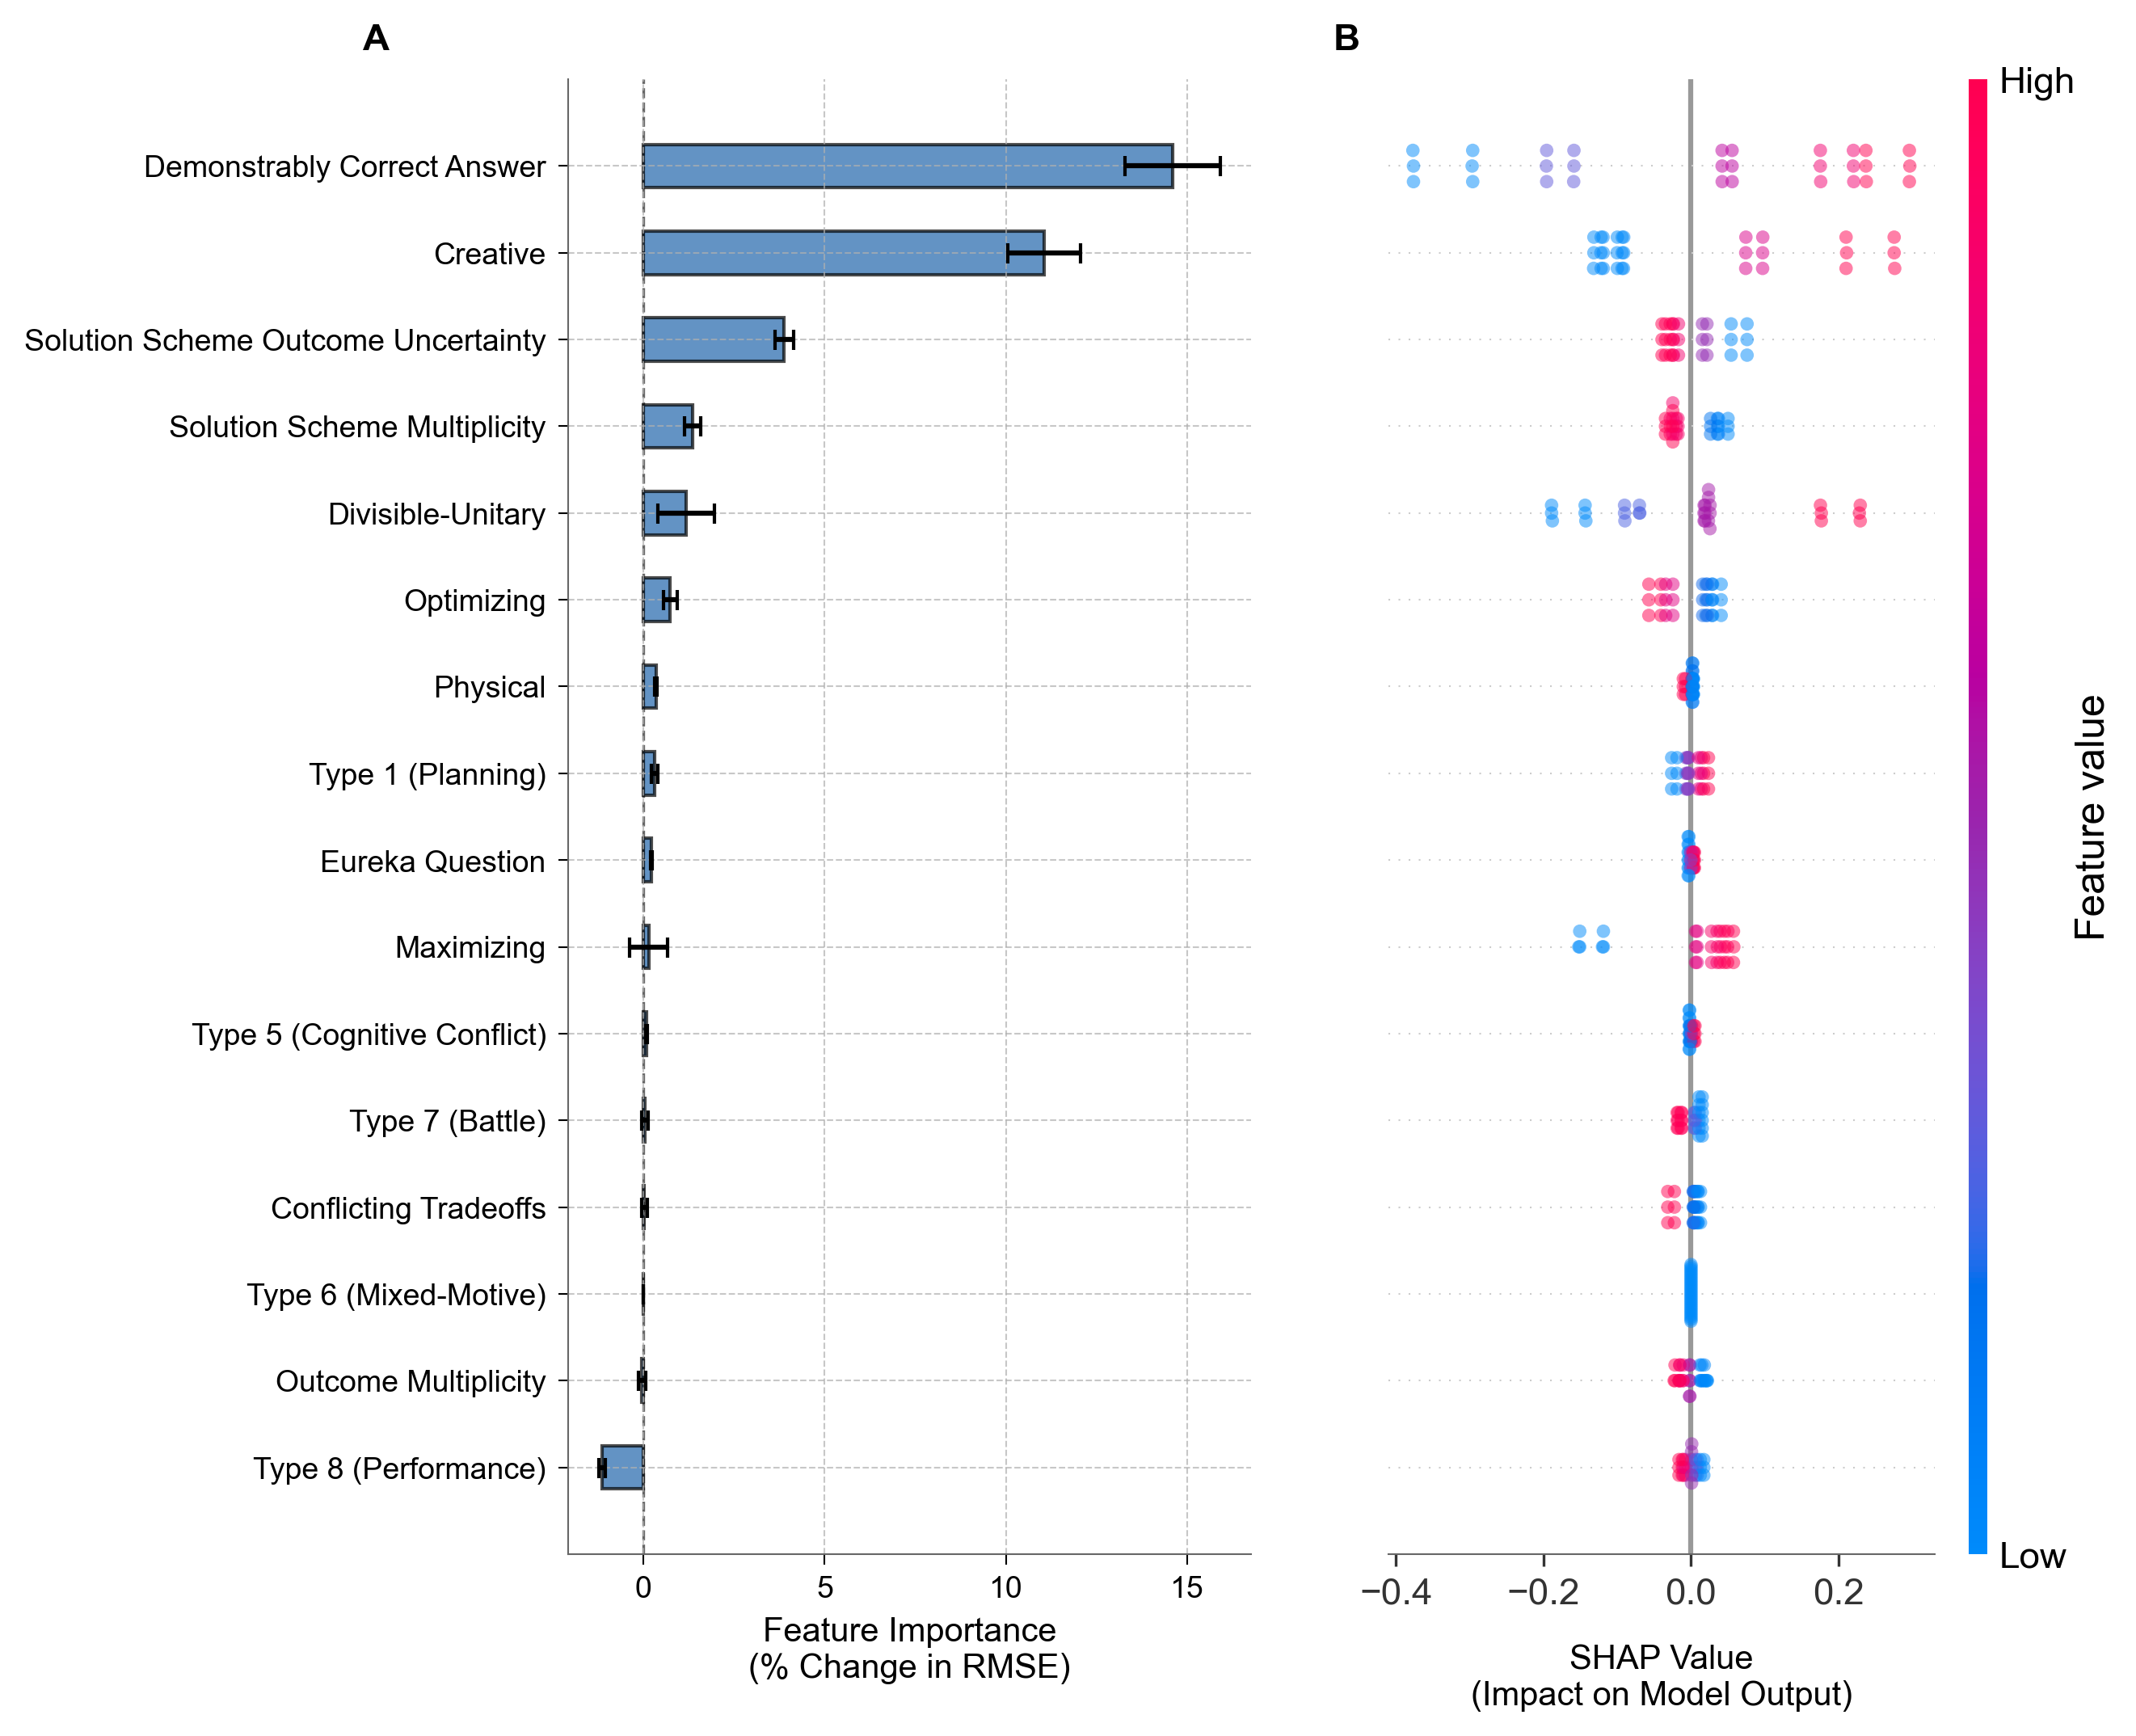

In [26]:
# ENet with interactions - Weak Synergy (Train Waves 1-2, Predict Wave 3)
plot_combined_feature_importance(
    model = MODELS["Task Space"]["E-Net"]["Wave 2"]["weak"],
    wave_a_data = TRAIN_TEST_DATA["Wave 2"]["train"],
    wave_b_data = TRAIN_TEST_DATA["Wave 2"]["test"],
    ivs = basic_IVs,
    dv_type = "weak",
    model_type = "E-Net",
    save_path = '../outputs/combined_importance_enet_weak_wave3.png'
)

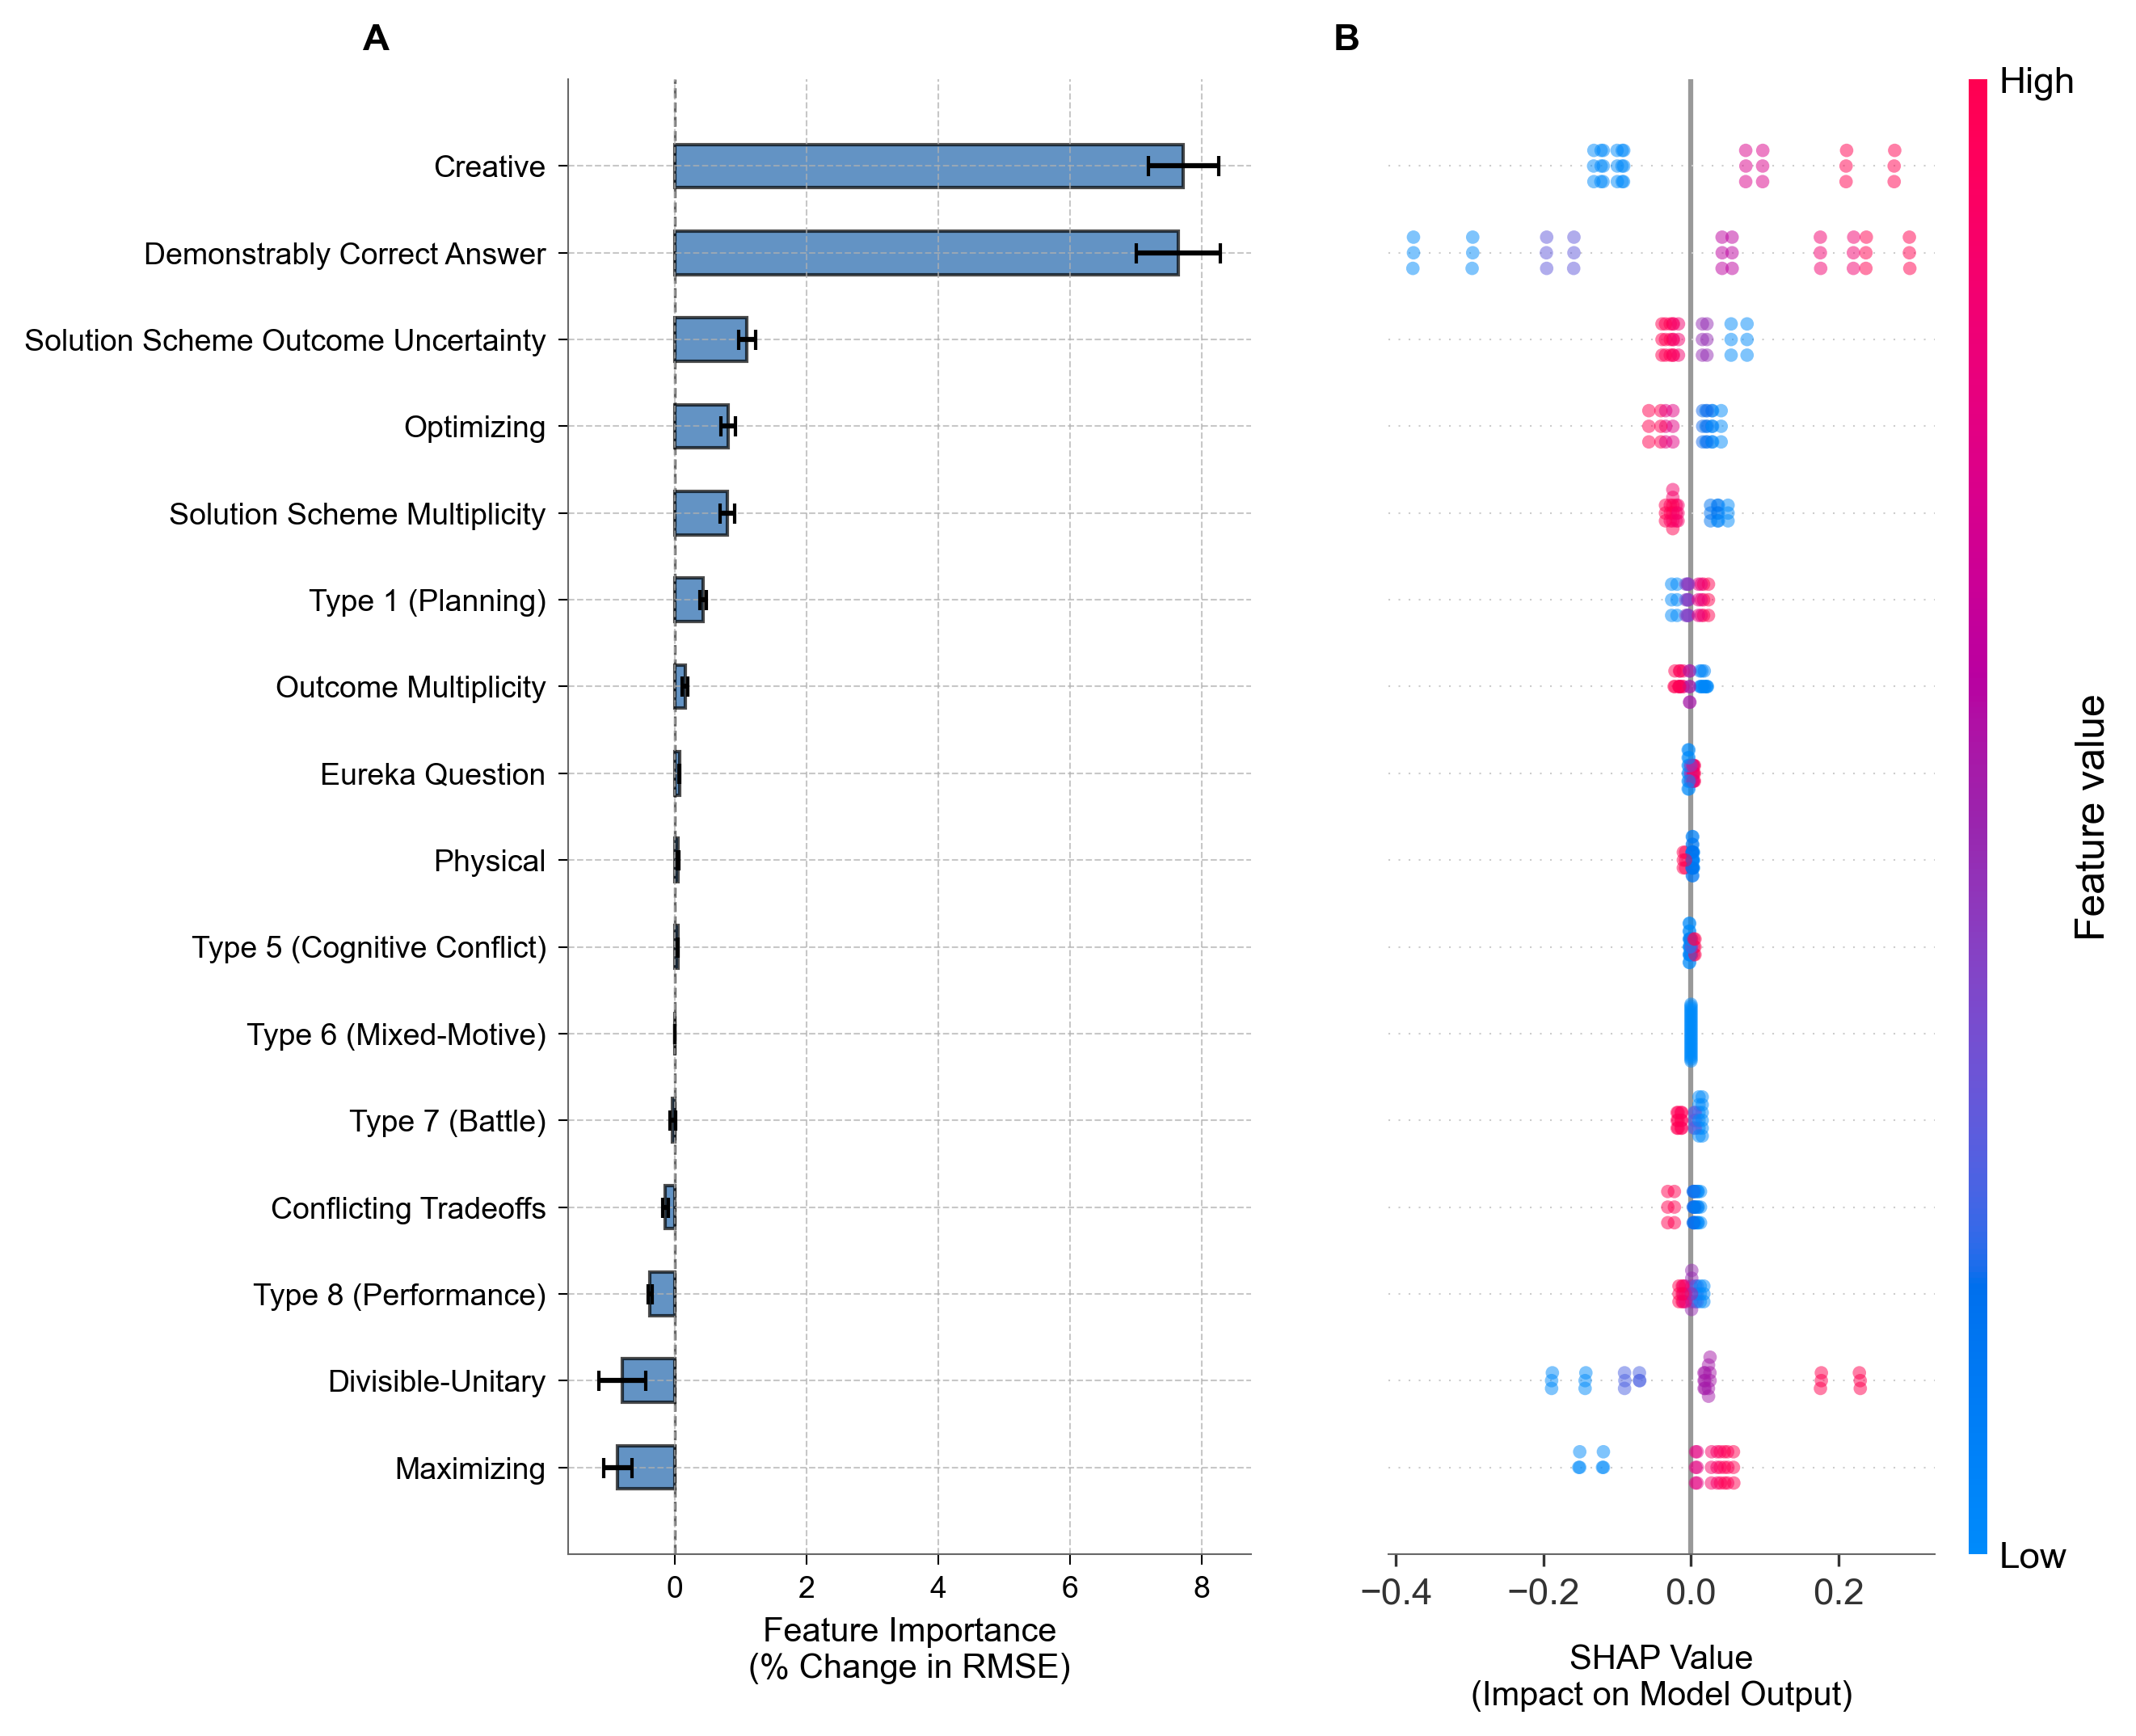

In [27]:
# E-Net - Strong Synergy (Train Waves 1-2, Predict Wave 3)
plot_combined_feature_importance(
    model = MODELS["Task Space"]["E-Net"]["Wave 2"]["weak"],
    wave_a_data = TRAIN_TEST_DATA["Wave 2"]["train"],
    wave_b_data = TRAIN_TEST_DATA["Wave 2"]["test"],
    ivs = basic_IVs,
    dv_type = "strong",
    model_type = "E-Net",
    save_path = '../outputs/combined_importance_enet_strong_wave3.png'
)